Team members: Jeevan Rai & Arman Kamal

In [ ]:
!pip install tensorflow==2.16.2

In [ ]:
!pip install tqdm==4.66.3

In [ ]:
!pip install numpy==1.26

In [ ]:
!pip install tf-keras==2.16

In [ ]:
!pip install matplotlib==3.5.0

In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
import torch
import numpy as np
import tensorflow as tf
import tf_keras
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data import Dataset
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import accuracy_score
from torch import nn
from tqdm.notebook import tqdm, trange
import matplotlib
import matplotlib.pyplot as plt
import time
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
from PIL import Image
from IPython.display import display
import re

In [ ]:
# Check versions
print(torch.__version__)
print(tf.__version__)
print(tf_keras.__version__)
print(np.__version__)
print(matplotlib.__version__)

# Prepare the dataset

In [ ]:
# Load MS MARCO v1.1 (passage ranking version)
dataset = load_dataset("microsoft/ms_marco", "v1.1")

In [ ]:
# Let's look at the dataset structure
dataset

DatasetDict({
    validation: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 10047
    })
    train: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 82326
    })
    test: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 9650
    })
})

**Dataset MS MARCO Overview**  
MS MARCO (Microsoft MAchine Reading COmprehension) is a large-scale, real-world dataset created by Microsoft and sourced from Bing search engine queries. It is specifically designed to support research in:


*   Machine Reading Comprehension (MRC)
*   Question Answering (QA)
*   Passage Ranking
*   Keyphrase Extraction
*   Conversational Search



Shown below is a quick look at each features that will be used in this report:

*   query: A human-generated Bing search query.
*   query_type: The semantic category of the query, such as location, numeric, person, description, and entity


Dataset Structure: The MS MARCO dataset is split into three main subsets:

*   Training Set: ~82,000 samples
*   Validation Set: ~10,000 samples
*   Test Set: ~9,000 samples  
Each set is organized in a dictionary-like format suitable for machine learning pipelines.


Useful Links:  
https://microsoft.github.io/msmarco/  
https://github.com/microsoft/MSMARCO-Question-Answering

In [ ]:
# Count rows in each split
for split in dataset:
    print(f"{split.capitalize()} Set: {len(dataset[split])} rows")

Validation Set: 10047 rows
Train Set: 82326 rows
Test Set: 9650 rows


In [ ]:
# Convert each datasets into separate panda dataframe
train_df = pd.DataFrame(dataset["train"])
validation_df = pd.DataFrame(dataset["validation"])
test_df = pd.DataFrame(dataset["test"])

Since we are only working with queries (training feature) and their corresponding types (target), we will remove unnecessary columns from the dataset.

In [ ]:
# Remove unnecessary feature columns from each datasets
train_df = train_df.drop(columns=["answers", "passages", "query_id", "wellFormedAnswers"])
test_df = test_df.drop(columns=["answers", "passages", "query_id", "wellFormedAnswers"])
validation_df = validation_df.drop(columns=["answers", "passages", "query_id", "wellFormedAnswers"])

In [ ]:
# Save the datasets to a CSV file to avoid future downloads
train_df.to_csv("train_df.csv", index=False)
validation_df.to_csv("validation.csv", index=False)
test_df.to_csv("test_df.csv", index=False)

In [ ]:
# Load the saved datasets and convert them to pandas dataframe
train_df = pd.read_csv("train_df.csv")
validation_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test_df.csv")

In [ ]:
# Check for missing values
train_df.isnull().sum()
validation_df.isnull().sum()
test_df.isnull().sum()

query         0
query_type    0
dtype: int64

In [ ]:
# Check to ensure all datasets have all 5 labels
train_df["query_type"].nunique()
validation_df["query_type"].nunique()
test_df["query_type"].nunique()

5

In [ ]:
# Encode the labels

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'query_type' column and store the result in a new column 'query_type_encoded'
train_df['query_type_encoded'] = label_encoder.fit_transform(train_df['query_type'])
validation_df['query_type_encoded'] = label_encoder.fit_transform(validation_df['query_type'])
test_df['query_type_encoded'] = label_encoder.fit_transform(test_df['query_type'])

In [ ]:
# encoded labels
print (dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{'description': 0, 'entity': 1, 'location': 2, 'numeric': 3, 'person': 4}


Based on the encoded labels shown above, the models will be trained to predict the targets.

In [ ]:
# Assign feature and target column

# TRAIN
y_train = train_df["query_type_encoded"]

# VALIDATION
y_val = validation_df["query_type_encoded"]

# TEST
y_test = test_df["query_type_encoded"]

# Baseline model

We will load the pretrained BERT uncased model. We want to perform classification, so we will need to get BertForSequenceClassifiction as it includes a fully connected classification layer on top of the BERT model

In [ ]:
# Load the BERT model
model_base = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=5,   # 5 targets
                                                      output_hidden_states=False
                                                     )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Let's evaluate the base model architecture
model_base

**Base model architecture:**


*   We have BERT model that contains embeddings, word_embeddings, position_embeddings, token_type_embeddings, LayerNorm, and dropout
*   It then goes into BertEncoder that is simply 12 identical layers where we have self attention layer, query, key, value, and dropout

*   Then it goes through couple of dense layers: output "BertSelfOutput, intermediate "BertIntermediate", and output "BertOutput
*   Then it goes through a pooling layer "BertPooler" that has output of 768 (linear)

*   Finally it goes through a classifier layer (untrained) that expects intput of 768 and will have output of 20 (number of layers for classification)













In [ ]:
# place the based model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_base.to(device)

# Check if CUDA is available
print("Is CUDA available?     ", torch.cuda.is_available())

Is CUDA available?      True


## Tokenization

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Tokenize the queries in train_df
train_encodings = tokenizer(
    train_df['query'].tolist(),       # Input text
    truncation=True,                  # Truncate to max length
    padding=True,                     # Pad to max length
    max_length=128,                   # Optional: set max sequence length
    return_tensors="pt"               # Return PyTorch tensors
)

In [ ]:
print(train_encodings.keys())
print(train_encodings['input_ids'].shape)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([82326, 52])


Looking at the structure of the tokenized training data, we can see that we have all three essential componentes. We have 82,326 queries that have been tokenized into a sequence of 52 tokens per query. We will performan same operation for the validation and testing samples.

In [ ]:
# Tokenize the queries in validation_df
validation_encodings = tokenizer(
    validation_df['query'].tolist(),       # Input text
    truncation=True,                  # Truncate to max length
    padding=True,                     # Pad to max length
    max_length=128,                   # Optional: set max sequence length
    return_tensors="pt"               # Return PyTorch tensors
)

# Tokenize the queries in test_df
test_encodings = tokenizer(
    test_df['query'].tolist(),       # Input text
    truncation=True,                  # Truncate to max length
    padding=True,                     # Pad to max length
    max_length=128,                   # Optional: set max sequence length
    return_tensors="pt"               # Return PyTorch tensors
)

In [ ]:
print(validation_encodings.keys())
print(validation_encodings['input_ids'].shape)

print(test_encodings.keys())
print(test_encodings['input_ids'].shape)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([10047, 34])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([9650, 28])


## Prepare datasets

Since BERT models expect input in a specific format: batches of input_ids, attention_mask, and labels, all as tensors, we will wrap these inputs in a Dataset class.

In [ ]:
train_df.head()

,query,query_type,query_type_encoded
0,what is rba,description,0
1,was ronald reagan a democrat,description,0
2,how long do you need for sydney and surroundin...,numeric,3
3,price to install tile in shower,numeric,3
4,why conversion observed in body,description,0


In [ ]:
# Create PyTorch custom dataset class to build train, test, and validation datasets
class QueryDataset(Dataset):

    def __init__(self, encodings, labels):
        self.encodings = encodings  #dict returned by tokenizer
        self.labels = labels  # list of classification labels

    # To allow PyTorch to fetch a single samply by index (what BERT expects)
    def __getitem__(self, idx):

        # get input_ids & attention_mask for one item. convert label to Pytorch tensors
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'token_type_ids': self.encodings['token_type_ids'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    # to return total number of samples
    def __len__(self):
        return len(self.labels)

Now using the class above, let's create the three datasets. Each gets tokenized inputs (encodings) and a list of labels.

In [ ]:
train_dataset = QueryDataset(train_encodings, y_train.tolist())
val_dataset = QueryDataset(validation_encodings, y_val.tolist())
test_dataset = QueryDataset(test_encodings, y_test.tolist())

In [ ]:
print(train_df.head(1))
train_dataset[0]

         query   query_type  query_type_encoded
0  what is rba  description                   0


{'input_ids': tensor([  101,  2054,  2003, 21144,  2050,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]),
 'labels': tensor(0)}

This is a quick check for first sample in train dataset. The dictionary is good for training the model.  

Now, let's create data loaders for each dataset. The batch size is 16. To maintain randomness, we will shuffle the samples.

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Train base model

We will train the base model for 4 epochs and see if it converges.

In [ ]:
# training iterations
epochs = 4

# define the optimizer (no frozen layers so updating all parameters)
optimizer = Adam(model_base.parameters(), lr=2e-5)

Batch_size = 16
train_size = len(train_df)
val_size = len(validation_df)

In [ ]:
# setup tracking for training
history_base = {}  # empty dict to store training history of the base model
history_base['val_loss'] = []  # stores validation loss values
history_base['train_loss'] = []  # stores training loss values

# setting up a progress bar for epochs
with trange(epochs, desc="Epoch") as pbar:

    for epoch in pbar:
        model_base.train()  # put the model in training mode
        total_loss  = 0.0  # track the training loss

        # iterate over training data in batchs using train_dataloader.
        for batch in tqdm(train_dataloader, desc=f"Training {epoch}", total=len(train_dataloader), leave=False):

            # send batch (tuple of below input parameters & labels) to GPU and separate for the model
            batch = {k: v.to(device) for k, v in batch.items()}   # Send all tensor values to GPU
            input_ids, input_mask, input_types, labels = batch  # unpack those parameters of the tuple

            # pass these parameters thru model to perform forward pass. This will compute model's output (includes training loss)
            output = model_base(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch['token_type_ids'],
                labels=batch['labels']
            )

            # back propagation
            output.loss.backward() # computes gradients by backpropagation using the loss
            optimizer.step() # use gradients in optimizer to update model's parameters
            optimizer.zero_grad() # clear out gradients of optimized tensors to avoid accumulation of gradients between different batches

            # keep track of total train loss. Need to multiply loss per sample by batch size for total loss
            total_loss += output.loss.item() * batch['input_ids'].size(0)

        # calcualte the avg. training loss and add it to the train_loss
        total_loss  = total_loss / train_size
        history_base['train_loss'].append(total_loss)


        # print the train loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

        # at end of epoch, report the evaluation
        model_base.eval()  # Set model to evaluation mode (droput layers and other training specific operations are turned off)
        total_loss  = 0.0  #rest the total loss to 0 to track the validation loss

        # turn of gradient calculation as we're only evaluating the model
        with torch.no_grad():

            # evaluation in batches (same as above)
            for batch in tqdm(val_dataloader, desc=f"Evaluating {epoch}", total = len(val_dataloader), leave=False):
                #batch = tuple(s.to(device) for s in batch) # send to GPU
                batch = {k: v.to(device) for k, v in batch.items()}

                output = model_base(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    token_type_ids=batch['token_type_ids'],
                    labels=batch['labels']
                )

                total_loss += output.loss.item() * batch['input_ids'].size(0)

            total_loss  = total_loss / val_size
            history_base['val_loss'].append(total_loss)

        # print the eval loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Training 0:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 0:   0%|          | 0/628 [00:00<?, ?it/s]

Training 1:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 1:   0%|          | 0/628 [00:00<?, ?it/s]

Training 2:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 2:   0%|          | 0/628 [00:00<?, ?it/s]

Training 3:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 3:   0%|          | 0/628 [00:00<?, ?it/s]

In [ ]:
history_base

{'train_loss': [0.19646199051361976,
  0.10580222832797939,
  0.061439703220511135,
  0.037884900581705044],
 'val_loss': [0.1563682948878105,
  0.1359175957798308,
  0.1737739885494434,
  0.21789838334074965]}

Using the trained base model, we will compute its accuracy on the test dataset.

In [ ]:
# store the base model accuracy
history_base['test_accuracy'] = []

# get predicted labels and true labels
all_preds_base = []
all_labels_base = []

 # Run evaluation without tracking gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc=f"Evaluating {epoch}", total=len(test_dataloader), leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']

        output = model_base(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            labels=labels
        )

        # Predictions: take argmax if multi-class (logits), or round for binary (sigmoid output)
        logits = output.logits
        preds = torch.argmax(logits, dim=1) if logits.shape[1] > 1 else torch.round(torch.sigmoid(logits)).squeeze()

        # Store predictions and labels as numpy arrays
        all_preds_base.extend(preds.cpu().numpy())
        all_labels_base.extend(labels.cpu().numpy())


# Compute accuracy
accuracy_base = accuracy_score(all_labels_base, all_preds_base)
history_base['test_accuracy'].append(accuracy_base)

print(f"Base model accuracy with 4 epochs: {history_base['test_accuracy']}")

Evaluating 3:   0%|          | 0/604 [00:00<?, ?it/s]

Base model accuracy with 4 epochs: [0.9483937823834196]


In [ ]:
# Save the trained model & tokenizer
base_model_4epochs = "bert_model_base_4epochs"

# Save the model
model_base.save_pretrained(base_model_4epochs)

# Save the tokenizer
tokenizer.save_pretrained(base_model_4epochs)

print(f"Base Model and tokenizer saved to: {base_model_4epochs}")

Base Model and tokenizer saved to: bert_model_base_4epochs


Let's run the base model for 10 epochs and see if the base model need more runs to converge.

In [ ]:
# let's run the training for more epochs

# training iterations
epochs_2 = 10

# setup tracking for training
history_base_2 = {}  # empty dict to store training history of the base model
history_base_2['val_loss'] = []  # stores validation loss values
history_base_2['train_loss'] = []  # stores training loss values

# setting up a progress bar for epochs
with trange(epochs_2, desc="Epoch") as pbar:

    for epoch in pbar:
        model_base.train()  # put the model in training mode
        total_loss  = 0.0  # track the training loss

        # iterate over training data in batchs using train_dataloader.
        for batch in tqdm(train_dataloader, desc=f"Training {epoch}", total=len(train_dataloader), leave=False):

            # send batch (tuple of below input parameters & labels) to GPU and separate for the model
            batch = {k: v.to(device) for k, v in batch.items()}   # Send all tensor values to GPU
            input_ids, input_mask, input_types, labels = batch  # unpack those parameters of the tuple

            # pass these parameters thru model to perform forward pass. This will compute model's output (includes training loss)
            output = model_base(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch['token_type_ids'],
                labels=batch['labels']
            )

            # back propagation
            output.loss.backward() # computes gradients by backpropagation using the loss
            optimizer.step() # use gradients in optimizer to update model's parameters
            optimizer.zero_grad() # clear out gradients of optimized tensors to avoid accumulation of gradients between different batches

            # keep track of total train loss. Need to multiply loss per sample by batch size for total loss
            total_loss += output.loss.item() * batch['input_ids'].size(0)

        # calcualte the avg. training loss and add it to the train_loss
        total_loss  = total_loss / train_size
        history_base_2['train_loss'].append(total_loss)


        # print the train loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

        # at end of epoch, report the evaluation
        model_base.eval()  # Set model to evaluation mode (droput layers and other training specific operations are turned off)
        total_loss  = 0.0  #rest the total loss to 0 to track the validation loss

        # turn of gradient calculation as we're only evaluating the model
        with torch.no_grad():

            # evaluation in batches (same as above)
            for batch in tqdm(val_dataloader, desc=f"Evaluating {epoch}", total = len(val_dataloader), leave=False):
                batch = {k: v.to(device) for k, v in batch.items()}

                output = model_base(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    token_type_ids=batch['token_type_ids'],
                    labels=batch['labels']
                )

                total_loss += output.loss.item() * batch['input_ids'].size(0)

            total_loss  = total_loss / val_size
            history_base_2['val_loss'].append(total_loss)

        # print the eval loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 0:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 0:   0%|          | 0/628 [00:00<?, ?it/s]

Training 1:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 1:   0%|          | 0/628 [00:00<?, ?it/s]

Training 2:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 2:   0%|          | 0/628 [00:00<?, ?it/s]

Training 3:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 3:   0%|          | 0/628 [00:00<?, ?it/s]

Training 4:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 4:   0%|          | 0/628 [00:00<?, ?it/s]

Training 5:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 5:   0%|          | 0/628 [00:00<?, ?it/s]

Training 6:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 6:   0%|          | 0/628 [00:00<?, ?it/s]

Training 7:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 7:   0%|          | 0/628 [00:00<?, ?it/s]

Training 8:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 8:   0%|          | 0/628 [00:00<?, ?it/s]

Training 9:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 9:   0%|          | 0/628 [00:00<?, ?it/s]

In [ ]:
history_base_2

{'val_loss': [0.21948117854112484,
  0.2304594312469883,
  0.2699852705062455,
  0.24869197952805613,
  0.24294359249553107,
  0.29608970191423456,
  0.27626349031070657,
  0.30229141236621526,
  0.30872391026812934,
  0.31571379649694215],
 'train_loss': [0.02673713952836368,
  0.020392036621667085,
  0.01631077961022771,
  0.01443043733529631,
  0.013995259102436906,
  0.01167001461556924,
  0.01121876860344445,
  0.010253207368765182,
  0.007963838392504377,
  0.007855089121618197]}

In [ ]:
# For 10 epochs run

# store the base model accuracy for 10 epochs
history_base_2['test_accuracy'] = []

# get predicted labels and true labels
all_preds_base_2 = []
all_labels_base_2 = []

 # Run evaluation without tracking gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc=f"Evaluating {epoch}", total=len(test_dataloader), leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']

        output = model_base(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            labels=labels
        )

        # Predictions: take argmax if multi-class (logits), or round for binary (sigmoid output)
        logits = output.logits
        preds = torch.argmax(logits, dim=1) if logits.shape[1] > 1 else torch.round(torch.sigmoid(logits)).squeeze()

        # Store predictions and labels as numpy arrays
        all_preds_base_2.extend(preds.cpu().numpy())
        all_labels_base_2.extend(labels.cpu().numpy())

        #total_loss += output.loss.item() * batch['input_ids'].size(0)


# Compute accuracy
accuracy_base_2 = accuracy_score(all_labels_base_2, all_preds_base_2)
history_base_2['test_accuracy'].append(accuracy_base_2)

print(f"Base model accuracy with 10 epochs: {history_base_2['test_accuracy']}")

Evaluating 9:   0%|          | 0/604 [00:00<?, ?it/s]

Base model accuracy with 10 epochs: [0.9498445595854922]


In [ ]:
# Save the trained model & tokenizer
base_model_10epochs = "bert_model_base_10epochs"

# Save the model
model_base.save_pretrained(base_model_10epochs)

# Save the tokenizer
tokenizer.save_pretrained(base_model_10epochs)

print(f"Base Model and tokenizer saved to: {base_model_10epochs}")

Base Model and tokenizer saved to: bert_model_base_10epochs


Compare the plots between 4 epochs and 10 epochs.

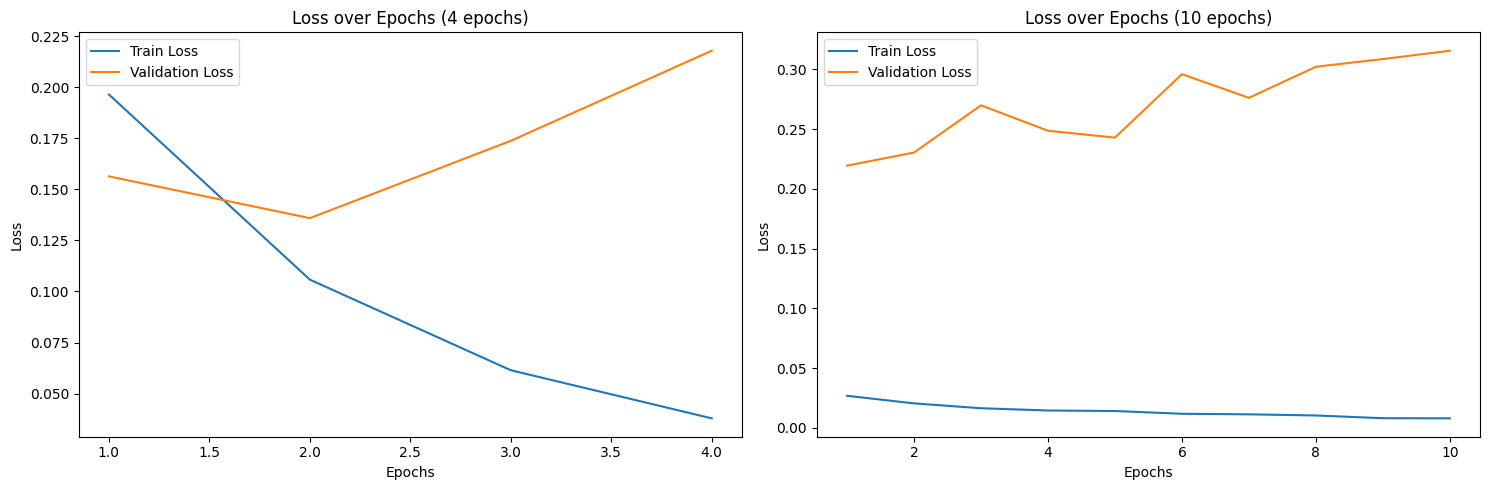

Accuracy of base model with 4 runs is [0.9483937823834196] and with 10 runs is [0.9498445595854922]


In [ ]:
# Plot the training and validation losses
epochs_range_1 = range(1, len(history_base['train_loss']) + 1)
epochs_range_2 = range(1, len(history_base_2['train_loss']) + 1)

fig, axes = plt.subplots(2, 2, figsize=(15, 5))

# Plot training and validation loss (4 epochs)
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, history_base['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_base['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (4 epochs)')
plt.legend()

# Plot training and validation loss (10 epochs)
plt.subplot(1, 2, 2)
plt.plot(epochs_range_2, history_base_2['train_loss'], label='Train Loss')
plt.plot(epochs_range_2, history_base_2['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (10 epochs)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Accuracy of base model with 4 runs is {history_base['test_accuracy']} and with 10 runs is {history_base_2['test_accuracy']}")

Looking at the plot for 4 epochs, we see that the training loss decreases steadily after around epoch 3. But looking at the validation loss, the loss starts to get worse after epoch 2 indicating ovefitting as the training loss continues to fall.  
But when we look into the plot for 10 epochs, we see that the model's training loss values really starts to remain unchanged after about epoch 4. After this epoch, the validation loss values starts to go up (get worse) despite occasional minor dips.  
Thus, we can say that the base model converges best by around epoch 4. Training the models for this many iterations allows enough time for the models to learn meaningful patterns without committing to extended training that leads to overfitting. We will therefore run the subsequent models for 4 epochs for all experiments.

# Experiment 1 (Freeze all layers except pooling + classifier)

In [ ]:
# Load the model
model_new = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5, output_hidden_states=False)

# Load the tokenizer
tokenizer_new = BertTokenizer.from_pretrained('bert-base-uncased')

# place the based model to GPU if available
model_new.to(device)

In [ ]:
# Go thru all parameters of the model and freeze entire model initially.
for param in model_new.parameters():
    param.requires_grad = False

# only train the parameters for pooler layer of BERT (final layer before our classifier layer)
for param in model_new.bert.pooler.parameters():
    param.requires_grad = True

# only train the classifier layer that we added to BERT model
for param in model_new.classifier.parameters():
    param.requires_grad = True


In [ ]:
trainable_params_new = sum(p.numel() for p in model_new.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params_new}")

Trainable parameters: 594437


For our first experiment, we will train only the final pooler layer and classifier layer with our training dataset injected with various levels noise (syntactic & semantic). With this setup, we have 594,437 trainable parameters.

## Injection of Noise

Next we want to inject "noise" in our original training dataset. The noise will be typos (syntactic noise) or misinterpretations (semantic noise).  
We will inject following levels of each type of noise and evaluate the impacts.  

*   8000 samples = 9.7% (typos)
*   250000 = 30.37% (typos)
*   41000 samples = 49.80% (typos)
*   57000 = 69.24% (typos)
*   8000 samples = 9.7% (misinterpretation)
*   25000 = 30.37% (misinterpretation)
*   40000 samples = 48.59% (misinterpretation)


### Syntactic Noise (Typos)

Let's inject the training dataset with various levels of syntactic noise. Each sample will be injected with one type of typo ensuring that all of the samples will be injected with different but one type of typo.

In [ ]:
# set seed for reproducibility
random_state = 42

# Select n random samples from train_df dataset
sampled = train_df['query'].sample(n=57000, random_state=random_state)
samples_idx = sampled.index  # Save the original indices
sampled_df = sampled.reset_index(drop=True)  # Reset index for clean iteration

In [ ]:
print(sampled_df)
print(samples_idx)

0                                   where is burnwell ala
1                      what constitutes connective tissue
2       how much does a rehabilitation center employee...
3               what distinctive markings do caimans have
4             at which vertebrae does the spinal cord end
                              ...                        
7995                       why did the renaissance happen
7996           what form of energy does a battery produce
7997                                is albinism recessive
7998                   how much does a simple patent cost
7999                                    cost of a khopesh
Name: query, Length: 8000, dtype: object
Index([54125, 32584,  9894,  3269, 23273, 49658, 52747, 41754, 80757, 33548,
       ...
        6501, 54135, 66637,  5548, 21254, 81490, 10835, 23881, 72438, 47943],
      dtype='int64', length=8000)


Heare all the 8000 samples randomly selected from the training dataset along with their indices. We will do the same for all levels of noise.

In [ ]:
# Function to introduce a typo per text sample
def introduce_typo(word, seed=None, typo_type="swap"):

    # skip samples with only 1 word
    if len(word) <= 1:
        return word

    # ensure randomness for reproducibility
    random.seed(seed)


    if typo_type == 'swap' and len(word) > 1:
        i = random.randint(0, len(word) - 2)
        return word[:i] + word[i+1] + word[i] + word[i+2:]

    elif typo_type == 'delete':
        i = random.randint(0, len(word) - 1)
        return word[:i] + word[i+1:]

    elif typo_type == 'replace':
        i = random.randint(0, len(word) - 1)
        new_char = random.choice('abcdefghijklmnopqrstuvwxyz')
        return word[:i] + new_char + word[i+1:]

    return word

Here we will inject random noise like "swap" which is swapping two adjacent characters, "delete" which is to remove a character, and "replace" to replace a character with a random letter.

In [ ]:
# Function to apply introduce_typo() to every word in a text sample
def add_typos_to_text(text, seed_base):

    words = text.split()  #split the word from each sample
    random.seed(seed_base)   # Set the seed for reproducibility

    # Pick one random word index in the sample
    typo_word_idx = random.randint(0, len(words) - 1)

    # Choose a random typo type
    typo_type = random.choice(['swap', 'delete', 'replace'])

    # Generate a seed just for the selected word for reproducibility
    word_seed = hash((seed_base, typo_word_idx, words[typo_word_idx])) % (2**32)

    # Apply typo only to the selected word
    words[typo_word_idx] = introduce_typo(words[typo_word_idx], word_seed, typo_type)

    return ' '.join(words)

Now let's apply the above function to randomly pick one type of typo and modify a training sample based on that selected noise.

In [ ]:
# Apply the typo function to each row in sampled_df
sampled_df_with_typos = sampled_df.apply(lambda x: add_typos_to_text(x, seed_base=random_state))

We will inject different amount of typos in the original dataset, and evaluate the impact on model performance.

In [ ]:
# Make a copy to avoid modifying original train_df
train_df_typos = train_df.copy()

# Replace the selected rows' 'query' with the noisy version
train_df_typos.loc[samples_idx, 'query'] = sampled_df_with_typos.values

In [ ]:
# Compare old vs new for a few samples
pd.DataFrame({
    'original': train_df.loc[samples_idx, 'query'].values[:10],
    'typos': train_df_typos.loc[samples_idx, 'query'].values[:10]
})

,original,typos
0,where is burnwell ala,wehre is burnwell ala
1,what constitutes connective tissue,waht constitutes connective tissue
2,how much does a rehabilitation center employee...,how mcuh does a rehabilitation center employee...
3,what distinctive markings do caimans have,what distinctive markings do caimans ahve
4,at which vertebrae does the spinal cord end,at hwich vertebrae does the spinal cord end
5,concrete bulkhead linear foot cost,cocnrete bulkhead linear foot cost
6,are sessile polyps cancerous,rae sessile polyps cancerous
7,how to get a disposition letter online,how to get a disposition lettre online
8,what are dipeptides,what are dpieptides
9,do i pay taxes on railroad retirement in alabama,do i pay taxes on railroad retirement in alabama


Here is the overveiw of first 10 samples from original training dataset "train_df" and dataset with typos "train_df_typos". For example, looking at the first sample, we can see that the word "where" from original training dataset has a typo "wehre" in the modified sample.  

Next, we will tokenize the updated queries. We will re-use previously tokenized validation and testing samples.

In [ ]:
# Tokenize the queries in train_df_typos
train_typos_encodings = tokenizer_new(
    train_df_typos['query'].tolist(),       # Input text
    truncation=True,                        # Truncate to max length
    padding=True,                           # Pad to max length
    max_length=128,                         # Optional: set max sequence length
    return_tensors="pt"                     # Return PyTorch tensors
)

In [ ]:
# check
print(train_typos_encodings.keys())
print(train_typos_encodings['input_ids'].shape)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([82326, 52])


In [ ]:
# Create training dataset (val_dataset and test_dataset will remain unchanged)
train_typos_dataset = QueryDataset(train_typos_encodings, y_train.tolist())

# create data loader for this training dataset. We can reuse the dataloaders for test and validation datasets.
train_typos_dataloader = DataLoader(train_typos_dataset, batch_size=16, shuffle=True)

Before training the customize new model, we wil need to redefine the optimizer after freezing certain layers in the model. If not redefined, the optimizer (previously defined) will try to update the frozen parameters even though they won't receive gradients leading to ineffective training or not even learning at all as the optimizer is mostly targeting frozen layers.
We want to update meaningful parameters so we need to redefine the optimizer for each experimentation.

In [ ]:
# define optimizer (use same same Adam optimizer with same learning rate)
optimizer_new = Adam(filter(lambda p: p.requires_grad, model_new.parameters()), lr=2e-5)

In [ ]:
# Number of epochs=4, optimizer = Adam, batch size = 16 (remain same)

# setup tracking for training
history_typos = {}  # empty dict to store training history of the new model
history_typos['val_loss'] = []  # stores validation loss values
history_typos['train_loss'] = []  # stores training loss values

# setting up a progress bar for epochs
with trange(epochs, desc="Epoch") as pbar:

    for epoch in pbar:
        model_new.train()  # put the model in training mode
        total_loss  = 0.0  # track the training loss

        # iterate over training data in batchs using train_typos_dataloader.
        for batch in tqdm(train_typos_dataloader, desc=f"Training {epoch}", total=len(train_typos_dataloader), leave=False):

            # send batch (tuple of below input parameters & labels) to GPU and separate for the model
            batch = {k: v.to(device) for k, v in batch.items()}   # Send all tensor values to GPU
            input_ids, input_mask, input_types, labels = batch  # unpack those parameters of the tuple

            # pass these parameters thru model to perform forward pass. This will compute model's output (includes training loss)
            output = model_new(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch['token_type_ids'],
                labels=batch['labels']
            )

            # back propagation
            output.loss.backward() # computes gradients by backpropagation using the loss
            optimizer_new.step() # use gradients in optimizer to update model's parameters
            optimizer_new.zero_grad() # clear out gradients of optimized tensors to avoid accumulation of gradients between different batches

            # keep track of total train loss. Need to multiply loss per sample by batch size for total loss
            total_loss += output.loss.item() * batch['input_ids'].size(0)

        # calcualte the avg. training loss and add it to the train_loss
        total_loss  = total_loss / train_size           # train_size remains unchanged
        history_typos['train_loss'].append(total_loss)


        # print the train loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

        # at end of epoch, report the evaluation
        model_new.eval()  # Set model to evaluation mode
        total_loss  = 0.0  #rest the total loss to 0 to track the validation loss

        # turn of gradient calculation as we're only evaluating the model
        with torch.no_grad():

            # evaluation in batches (same as above). No change to val_dataloader
            for batch in tqdm(val_dataloader, desc=f"Evaluating {epoch}", total = len(val_dataloader), leave=False):

                batch = {k: v.to(device) for k, v in batch.items()}

                output = model_new(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    token_type_ids=batch['token_type_ids'],
                    labels=batch['labels']
                )

                total_loss += output.loss.item() * batch['input_ids'].size(0)

            total_loss  = total_loss / val_size
            history_typos['val_loss'].append(total_loss)

        # print the eval loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")


print("Complete for 69.24% typos")

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Training 0:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 0:   0%|          | 0/628 [00:00<?, ?it/s]

Training 1:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 1:   0%|          | 0/628 [00:00<?, ?it/s]

Training 2:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 2:   0%|          | 0/628 [00:00<?, ?it/s]

Training 3:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 3:   0%|          | 0/628 [00:00<?, ?it/s]

Complete for 49.80% typos


In [ ]:
history_typos

{'val_loss': [0.3112747865321447,
  0.3118278593806778,
  0.30955742827408156,
  0.31099247896245336],
 'train_loss': [0.45703174599874175,
  0.45234659641153585,
  0.4519324364414893,
  0.4476625913984385]}

In [ ]:
# store the validation accuracy of the new model
history_typos['test_accuracy'] = []

# get predicted labels and true labels
all_preds_typos = []
all_labels_typos = []

 # Run evaluation without tracking gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc=f"Evaluating {epoch}", total=len(test_dataloader), leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']

        output = model_new(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            labels=labels
        )

        # Predictions: take argmax if multi-class (logits), or round for binary (sigmoid output)
        logits = output.logits
        preds = torch.argmax(logits, dim=1) if logits.shape[1] > 1 else torch.round(torch.sigmoid(logits)).squeeze()

        # Store predictions and labels as numpy arrays
        all_preds_typos.extend(preds.cpu().numpy())
        all_labels_typos.extend(labels.cpu().numpy())


# Compute accuracy
accuracy_typos = accuracy_score(all_labels_typos, all_preds_typos)
history_typos['test_accuracy'].append(accuracy_typos)
print("Complete")

Evaluating 3:   0%|          | 0/604 [00:00<?, ?it/s]

Complete


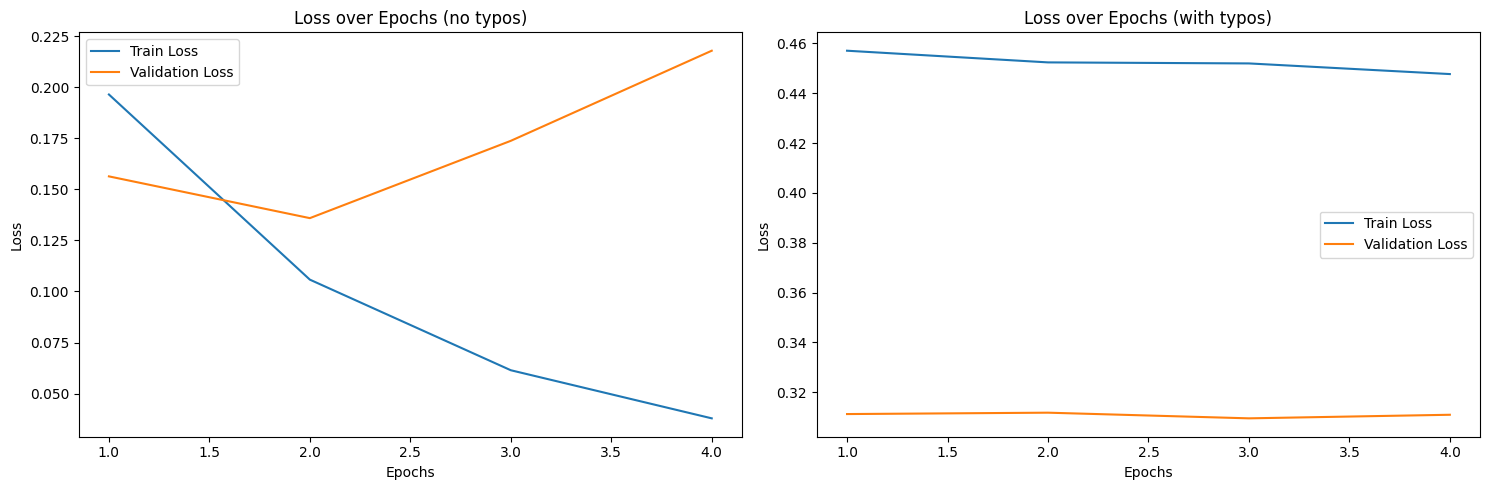

Accuracy for baseline model was [0.9483937823834196]
Accuracy for model with 69.24% typos is [0.895440414507772]


In [ ]:
# Plot the training and validation losses
epochs_range_1 = range(1, len(history_typos['train_loss']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss (with no typos)
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, history_base['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_base['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (no typos)')
plt.legend()

# Plot training and validation loss (with typos)
plt.subplot(1, 2, 2)
plt.plot(epochs_range_1, history_typos['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_typos['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (with typos)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Accuracy for baseline model was {history_base['test_accuracy']}")
print(f"Accuracy for model with 69.24% typos is {history_typos['test_accuracy']}")

comparing the new model with 69.24% noise against base model, we can see that the training and validation loss values start with much worse values (higher) than the base model. This trend remains same for all four epochs. So, the accuracy is also worse than the base model. This indicates that the model's generalization performance degrades with the injection of noise in the training dataset.

Comparison against other levels of noise is described below.

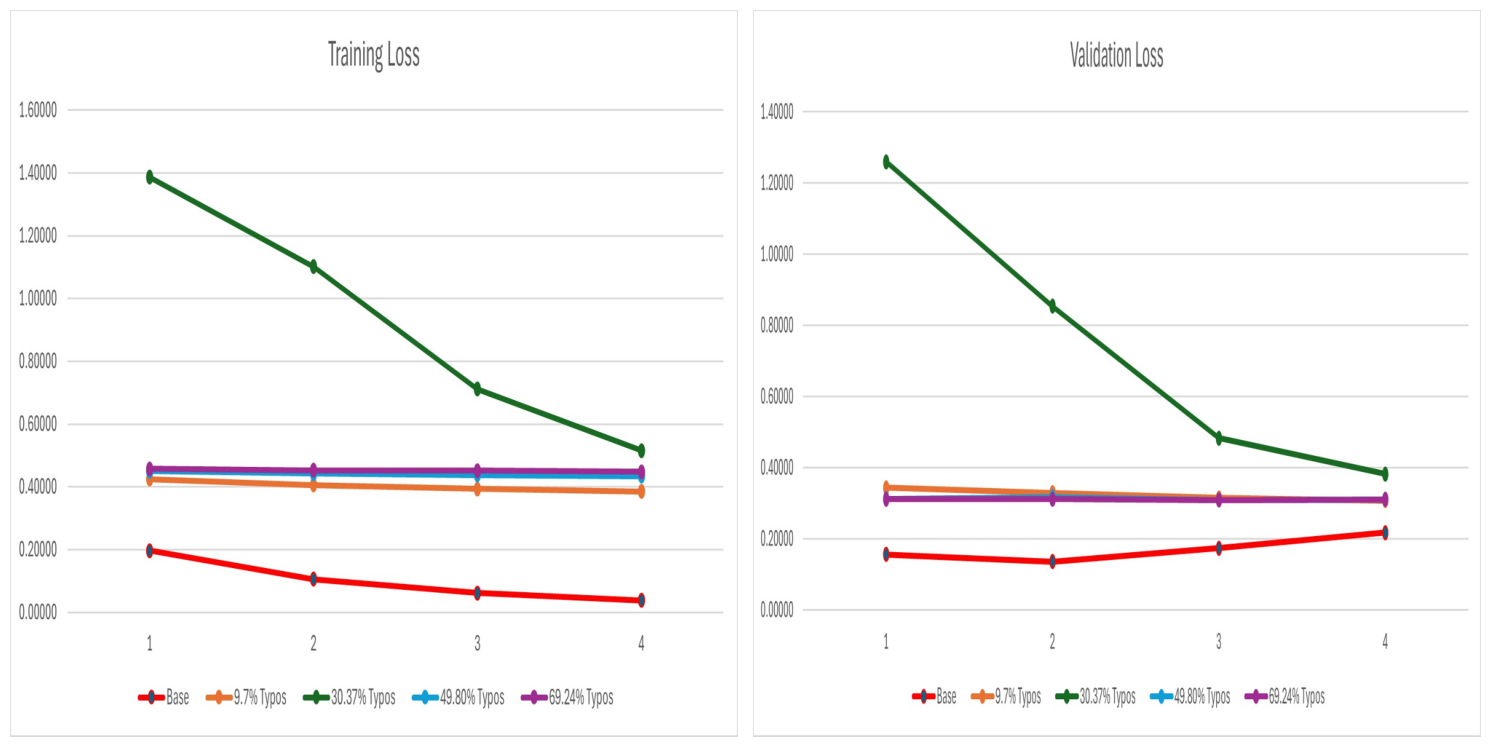

In [ ]:
from PIL import Image
from IPython.display import display

# Load images
typos_training_loss = Image.open("Typos_trainingloss.jpg")
typos_validation_loss = Image.open("Typos_validationloss.jpg")

# Resize images (adjust as needed)
new_size = (1000, 1000)  # Width x Height
typos_training_loss = typos_training_loss.resize(new_size)
typos_validation_loss = typos_validation_loss.resize(new_size)

# Display side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(typos_training_loss)
axes[0].axis('off')

axes[1].imshow(typos_validation_loss)
axes[1].axis('off')

plt.tight_layout()
plt.show()

Training loss increases noticeably with the introduction of noise, indicating that the model struggles to learn effectively from corrupted data. This trend is consistent across noise levels, with the 69.24% noise case showing the highest training loss initially. Interestingly, while 30.37% noise results in the worst early training loss, it improves more rapidly than other noisy conditions, showing a steep decline by epoch 4. This suggests that moderate levels of noise might push the model to adapt faster, even with limited capacity due to frozen layers.

Looking at the validation loss, we still see the same trend. The loss is much worse with noise of any noise.

Overall higher noise levels degrade performance, but the effect is non-linear. Moderate noise (30.37%) initially hurts training more than high noise, but the model recovers faster. Thus, even minor syntactic corruption significantly impacts learning and generalization, and the model’s resilience does not scale linearly with noise intensity.

### Semantic Noise (Misinterpretation)

Similarly, we will inject various levels of semantic noise into the training dataset by moving around letters from a word with an intention of creating misinterpretation of the query.

In [ ]:
# checking the number of samples that can be modified for our test case
print (train_df["query"].str.startswith("where").sum()) # Starts with "where"
print(train_df["query"].str.startswith("what").sum())  # Starts with "what"
print(train_df["query"].str.contains("long").sum())  # Contains the word "long"

3154
33401
4199


Based on these counts, we can only distort no more than 40,000 (~48.59%) training samples using the following approach.

In [ ]:
# Get indices matching the conditions
where_indices = set(train_df[train_df["query"].str.startswith("where")].index)
what_indices = set(train_df[train_df["query"].str.startswith("what")].index)
long_indices = set(train_df[train_df["query"].str.contains("long")].index)
long_indices_unique = long_indices - (where_indices | what_indices)  # Exclude indices already covered in where or what from long

# Combine all relevant indices into one pool
combined_indices_interpret = list(where_indices | what_indices | long_indices_unique)

# Randomly sample "x" indices from this combined pool
sampled_indices_interpret = random.sample(combined_indices_interpret, 40000)

# Extract the corresponding queries
sampled_df_misinterpret = train_df.loc[sampled_indices_interpret, 'query']

# Save the original indices
samples_idx_misinterpret = sampled_df_misinterpret.index

# change the interpretatin of the chosen samples
def misinterpret_where(text, seed=None):

    if seed is not None:
        random.seed(seed)

    # change the meaning of "location" by replacing "where" with who/how/why
    if text.startswith("where"):
        replacement = random.choice(["who", "how", "why"])
        return text.replace("where", replacement, 1)  # Replace only the first occurrence

    # change the meaning of "entity" by replacing "what" with where
    elif text.startswith("what"):
        return text.replace("what", "where", 1)  # Replace only the first occurrence

    # change the meaning of "numeric" by removing "long" only if not already changed
    elif "long" in text and not text.startswith("where") and not text.startswith("what"):
        return text.replace("long", "", 1)  # Replace only the first occurrence

    else:
        return text  # Return unchanged if it doesn't start with "Where"

# Apply the replacement function to change query interpretation
sampled_df_misinterpret = sampled_df_misinterpret.apply(lambda x: misinterpret_where(x, seed=random_state))


In [ ]:
print(len(combined_indices_interpret))
print(len(sampled_indices_interpret))

40623
40000


We have total of 40,623 samples from training dataset that meet the above requirements. We will inject different amounts of semantic noise in the dataset, and evalute the new model accordingly.  
We want to make sure that we have samples picked from each of the three cases randomly. So we will get the indices from these samples, combined them, and randomly pick them for samples to change their intepretations.

In [ ]:
# Make a copy to avoid modifying original train_df
train_df_misinterpret = train_df.copy()

# Replace the selected rows' 'query' with the noisy version
train_df_misinterpret.loc[sampled_indices_interpret, 'query'] = sampled_df_misinterpret.values

In [ ]:
# Compare old vs new for a few samples
pd.DataFrame({
    'original': train_df.loc[samples_idx_misinterpret, 'query'].values[:15],
    'misinterpretation ': train_df_misinterpret.loc[sampled_indices_interpret, 'query'].values[:15]
})

,original,misinterpretation
0,what is lego bionicle,where is lego bionicle
1,what is the largest inactive volcano in the world,where is the largest inactive volcano in the w...
2,what are dental caries,where are dental caries
3,what is the dimensions of a king size comforter,where is the dimensions of a king size comforter
4,what does reichstag mean,where does reichstag mean
5,what is pleurisy,where is pleurisy
6,how long do you cook a brisket,how do you cook a brisket
7,where in manhattan was gimbels located,why in manhattan was gimbels located
8,how long for broken fibula to heal completely,how for broken fibula to heal completely
9,what is ethane used for,where is ethane used for


In [ ]:
# Let's look at the samples picked for creating noise
print(train_df["query"].iloc[[141, 423, 893, 722]])

print(train_df_misinterpret["query"].iloc[[141, 423, 893, 722]])

141         how long is a prescription valid for
423            How long after birth until period
893             long term damage from oil spills
722    how long to cook chicken legs in the oven
Name: query, dtype: object
141         how  is a prescription valid for
423            How  after birth until period
893              term damage from oil spills
722    how  to cook chicken legs in the oven
Name: query, dtype: object


Look at the two outputs, we can see that the noise has been properly injected into the dataset.

In [ ]:
# Tokenize the queries in train_df_misinterpret
train_misinterpret_encodings = tokenizer_new(
    train_df_misinterpret['query'].tolist(),                         # Input text
    truncation=True,                               # Truncate to max length
    padding=True,                                  # Pad to max length
    max_length=128,                                # Optional: set max sequence length
    return_tensors="pt"                            # Return PyTorch tensors
)

In [ ]:
# Create training dataset (val_dataset and test_dataset will remain unchanged)
train_misinterpret_dataset = QueryDataset(train_misinterpret_encodings, y_train.tolist())

# create data loader for this training dataset. We can reuse the dataloaders for test and validation datasets.
train_misinterpret_dataloader = DataLoader(train_misinterpret_dataset, batch_size=16, shuffle=True)

In [ ]:
# define optimizer
optimizer_new = Adam(filter(lambda p: p.requires_grad, model_new.parameters()), lr=2e-5)

In [ ]:
# Number of epochs=4, optimizer = Adam, batch size = 16 (remain same)

# setup tracking for training
history_misinterpret = {}  # empty dict to store training history of the new model
history_misinterpret['val_loss'] = []  # stores validation loss values
history_misinterpret['train_loss'] = []  # stores training loss values

# setting up a progress bar for epochs
with trange(epochs, desc="Epoch") as pbar:

    for epoch in pbar:
        model_new.train()  # put the model in training mode
        total_loss  = 0.0  # track the training loss

        # iterate over training data in batchs using train_typos_dataloader.
        for batch in tqdm(train_misinterpret_dataloader, desc=f"Training {epoch}", total=len(train_misinterpret_dataloader), leave=False):

            # send batch (tuple of below input parameters & labels) to GPU and separate for the model
            batch = {k: v.to(device) for k, v in batch.items()}   # Send all tensor values to GPU
            input_ids, input_mask, input_types, labels = batch  # unpack those parameters of the tuple

            # pass these parameters thru model to perform forward pass. This will compute model's output (includes training loss)
            output = model_new(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch['token_type_ids'],
                labels=batch['labels']
            )

            # back propagation
            output.loss.backward() # computes gradients by backpropagation using the loss
            optimizer_new.step() # use gradients in optimizer to update model's parameters
            optimizer_new.zero_grad() # clear out gradients of optimized tensors to avoid accumulation of gradients between different batches

            # keep track of total train loss. Need to multiply loss per sample by batch size for total loss
            total_loss += output.loss.item() * batch['input_ids'].size(0)

        # calcualte the avg. training loss and add it to the train_loss
        total_loss  = total_loss / train_size           # train_size remains unchanged
        history_misinterpret['train_loss'].append(total_loss)


        # print the train loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

        # at end of epoch, report the evaluation
        model_new.eval()  # Set model to evaluation mode
        total_loss  = 0.0  #rest the total loss to 0 to track the validation loss

        # turn of gradient calculation as we're only evaluating the model
        with torch.no_grad():

            # evaluation in batches (same as above). No change to val_dataloader
            for batch in tqdm(val_dataloader, desc=f"Evaluating {epoch}", total = len(val_dataloader), leave=False):

                batch = {k: v.to(device) for k, v in batch.items()}

                output = model_new(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    token_type_ids=batch['token_type_ids'],
                    labels=batch['labels']
                )

                total_loss += output.loss.item() * batch['input_ids'].size(0)

            total_loss  = total_loss / val_size
            history_misinterpret['val_loss'].append(total_loss)

        # print the eval loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")


print("Complete for 48.59% misinterpretation")

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Training 0:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 0:   0%|          | 0/628 [00:00<?, ?it/s]

Training 1:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 1:   0%|          | 0/628 [00:00<?, ?it/s]

Training 2:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 2:   0%|          | 0/628 [00:00<?, ?it/s]

Training 3:   0%|          | 0/5146 [00:00<?, ?it/s]

Evaluating 3:   0%|          | 0/628 [00:00<?, ?it/s]

Complete for 48.59% misinterpretation


In [ ]:
history_misinterpret

{'val_loss': [0.41191561686360234,
  0.42342558237667927,
  0.4211623223193121,
  0.4283574341636066],
 'train_loss': [0.42549779017766315,
  0.41929357356490016,
  0.416505626961797,
  0.41172177763489487]}

In [ ]:
# store the model accuracy of the new model
history_misinterpret['test_accuracy'] = []

# get predicted labels and true labels
all_preds_misinterpret = []
all_labels_misinterpret = []

 # Run evaluation without tracking gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc=f"Evaluating {epoch}", total=len(test_dataloader), leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']

        output = model_new(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            labels=labels
        )

        # Predictions: take argmax if multi-class (logits), or round for binary (sigmoid output)
        logits = output.logits
        preds = torch.argmax(logits, dim=1) if logits.shape[1] > 1 else torch.round(torch.sigmoid(logits)).squeeze()

        # Store predictions and labels as numpy arrays
        all_preds_misinterpret.extend(preds.cpu().numpy())
        all_labels_misinterpret.extend(labels.cpu().numpy())


# Compute accuracy
accuracy_misinterpret = accuracy_score(all_labels_misinterpret, all_preds_misinterpret)
history_misinterpret['test_accuracy'].append(accuracy_misinterpret)

print("complete")

Evaluating 3:   0%|          | 0/604 [00:00<?, ?it/s]

complete


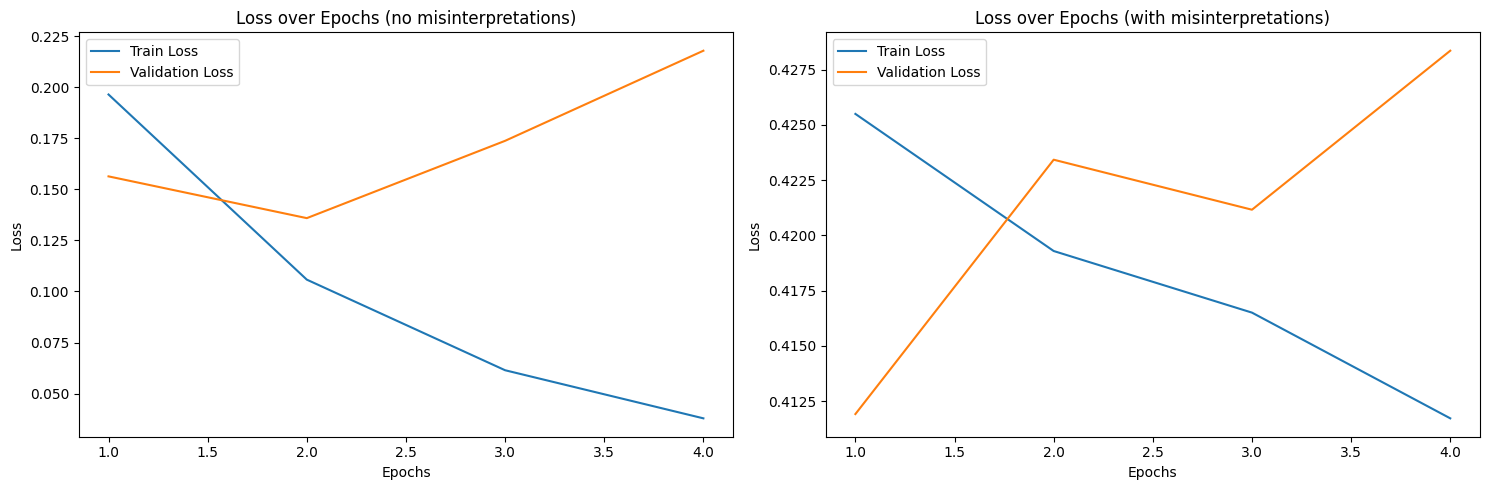

Accuracy for baseline model was [0.9483937823834196]
Accuracy for model with 48.59% misinterpreted samples is [0.8549222797927462]


In [ ]:
# Plot the training and validation losses
epochs_range_1 = range(1, len(history_misinterpret['train_loss']) + 1)

fig, axes = plt.subplots(2, 2, figsize=(15, 5))

# Plot training and validation loss (with no misinterpretations)
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, history_base['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_base['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (no misinterpretations)')
plt.legend()

# Plot training and validation loss (with misinterpretations)
plt.subplot(1, 2, 2)
plt.plot(epochs_range_1, history_misinterpret['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_misinterpret['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (with misinterpretations)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Accuracy for baseline model was {history_base['test_accuracy']}")
print(f"Accuracy for model with 48.59% misinterpreted samples is {history_misinterpret['test_accuracy']}")

Comparing the training plots between the base model and this new model with 48.59% of semantic noise, the training loss immediately starts with much worse value of 0.42 compared to 0.19 in base model. The same is true for the validation loss values as it starts with 0.41 here as compared to 0.15 in base model. Although, the plot appears to show that the loss values are climbing rapidly after first first epoch but looking at the actual values they seem to remain considerably same throughout the epochs. But let's look at the rest of the plots for other levels of noise.

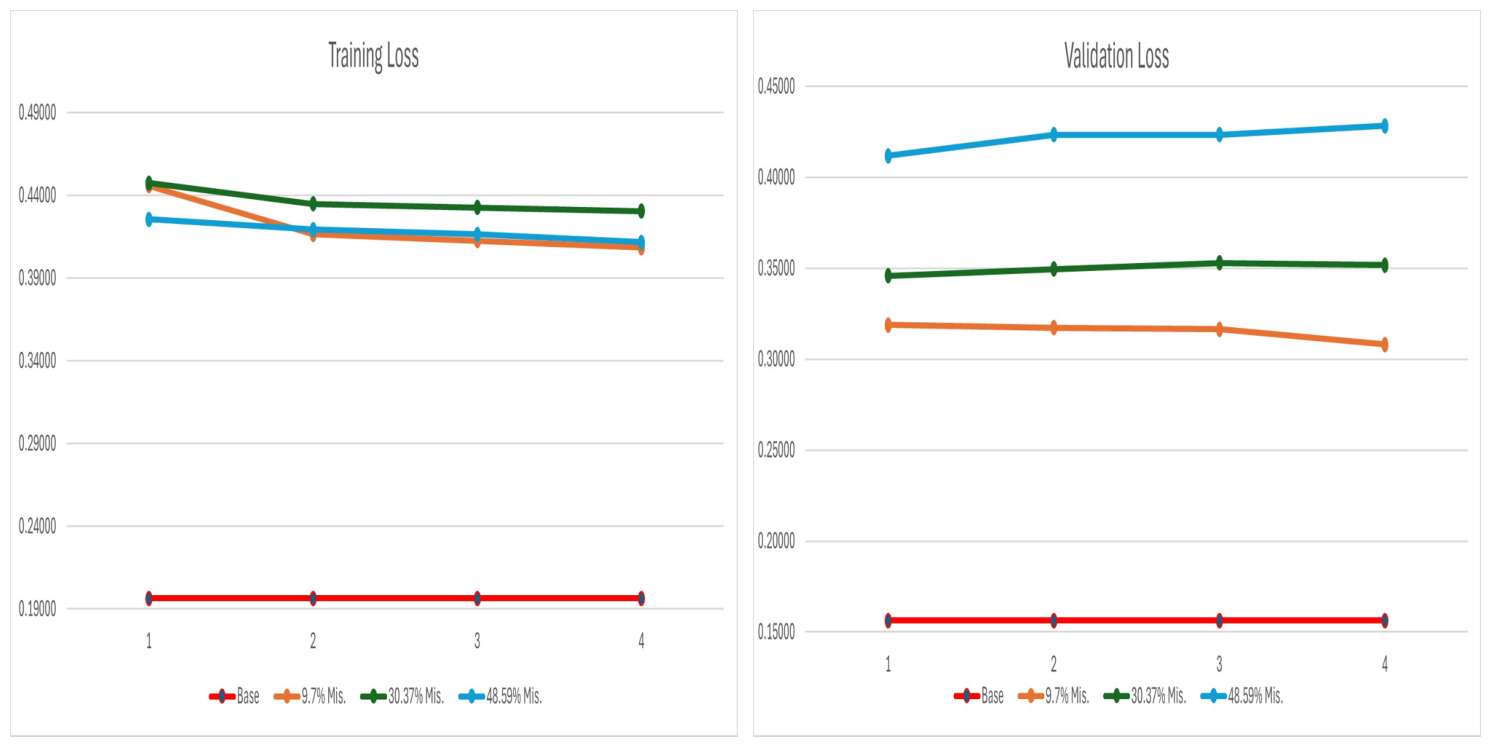

In [ ]:
# Load images
misinterpret_training_loss = Image.open("Misinterpret_trainingloss.jpg")
misinterpret_validation_loss = Image.open("Misinterpret_validationloss.jpg")

# Resize images (adjust as needed)
new_size = (1000, 1000)  # Width x Height
misinterpret_training_loss = misinterpret_training_loss.resize(new_size)
misinterpret_validation_loss = misinterpret_validation_loss.resize(new_size)

# Display side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes[0].imshow(misinterpret_training_loss)
axes[0].axis('off')

axes[1].imshow(misinterpret_validation_loss)
axes[1].axis('off')

plt.tight_layout()
plt.show()

Similar to the trends observed with syntactic noise, the injection of semantic noise—which likely introduces deeper disruptions in meaning—leads to a noticeable deterioration in training performance. Training loss remains significantly elevated across all epochs for noisy data, with the 30.37% noise level showing the worst training loss, making it a unique case. This may indicate that moderate semantic noise introduces enough inconsistency to confuse the model, while still being frequent enough to disrupt pattern learning, yet not enough to force the model to adjust or generalize as it might with heavier noise.

However, when we shift our focus to validation loss, a different trend emerges. The highest level of semantic noise (48.59%) produces the worst validation loss, and there appears to be a more linear relationship between noise level and validation loss. This suggests that as semantic corruption increases, the model's ability to generalize deteriorates progressively.

# Experiment 2 (Freeze 10-11 encoding layers)

In [ ]:
# Load the model
model_new1 = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5, output_hidden_states=False)

# Load the tokenizer
tokenizer_new = BertTokenizer.from_pretrained('bert-base-uncased')

# place the based model to GPU if available
model_new1.to(device)

We will unfreeze "encoder.layer.10" and "encoder.layer.11" layers. Since there are transformer layers 0-11, we are preventing the last two transformer blocks from training during gradient updates.   These are deeper layers so let's see if the new model is more or less sensitive to various types of noise.

In [ ]:
# Freeze all layers first
for param in model_new1.bert.parameters():
    param.requires_grad = False

# Then unfreeze the last 2 encoder layers
for name, param in model_new1.bert.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        param.requires_grad = True

# only train the parameters for pooler layer of BERT (final layer before our classifier layer)
for param in model_new1.bert.pooler.parameters():
    param.requires_grad = True

# only train the classifier layer that we added to BERT model
for param in model_new1.classifier.parameters():
    param.requires_grad = True

In [ ]:
trainable_params_new1 = sum(p.numel() for p in model_new1.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params_new1}")

Trainable parameters: 14770181


With this setup, there are 14,770,181 training parameters. These are more parameters compared to previous setup since we will be updating the weights for two additional encoding layers.

## Syntactic Noise (Typos)

In [ ]:
# define optimizer
optimizer_new1 = Adam(filter(lambda p: p.requires_grad, model_new1.parameters()), lr=2e-5)

In [ ]:
# Select n random samples from train_df dataset
sampled = train_df['query'].sample(n=57000, random_state=random_state)
samples_idx = sampled.index  # Save the original indices
sampled_df = sampled.reset_index(drop=True)  # Reset index for clean iteration

In [ ]:
# Apply the typo function to each row in sampled_df
sampled_df_with_typos = sampled_df.apply(lambda x: add_typos_to_text(x, seed_base=random_state))

In [ ]:
# Make a copy to avoid modifying original train_df
train_df_typos = train_df.copy()

# Replace the selected rows' 'query' with the noisy version
train_df_typos.loc[samples_idx, 'query'] = sampled_df_with_typos.values

In [ ]:
# Tokenize the queries in train_df_typos
train_typos_encodings = tokenizer_new(
    train_df_typos['query'].tolist(),       # Input text
    truncation=True,                        # Truncate to max length
    padding=True,                           # Pad to max length
    max_length=128,                         # Optional: set max sequence length
    return_tensors="pt"                     # Return PyTorch tensors
)

In [ ]:
# Create training dataset (val_dataset and test_dataset will remain unchanged)
train_typos_dataset = QueryDataset(train_typos_encodings, y_train.tolist())

# create data loader for this training dataset. We can reuse the dataloaders for test and validation datasets.
train_typos_dataloader = DataLoader(train_typos_dataset, batch_size=16, shuffle=True)

In [ ]:
# Number of epochs=4, optimizer = Adam, batch size = 16 (remain same)

# setup tracking for training
history_typos1 = {}  # empty dict to store training history of the new model
history_typos1['val_loss'] = []  # stores validation loss values
history_typos1['train_loss'] = []  # stores training loss values

# setting up a progress bar for epochs
with trange(epochs, desc="Epoch") as pbar:

    for epoch in pbar:
        model_new1.train()  # put the model in training mode
        total_loss  = 0.0  # track the training loss

        # iterate over training data in batchs using train_typos_dataloader.
        for batch in tqdm(train_typos_dataloader, desc=f"Training {epoch}", total=len(train_typos_dataloader), leave=False):

            # send batch (tuple of below input parameters & labels) to GPU and separate for the model
            batch = {k: v.to(device) for k, v in batch.items()}   # Send all tensor values to GPU
            input_ids, input_mask, input_types, labels = batch  # unpack those parameters of the tuple

            # pass these parameters thru model to perform forward pass. This will compute model's output (includes training loss)
            output = model_new1(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch['token_type_ids'],
                labels=batch['labels']
            )

            # back propagation
            output.loss.backward() # computes gradients by backpropagation using the loss
            optimizer_new1.step() # use gradients in optimizer to update model's parameters
            optimizer_new1.zero_grad() # clear out gradients of optimized tensors to avoid accumulation of gradients between different batches

            # keep track of total train loss. Need to multiply loss per sample by batch size for total loss
            total_loss += output.loss.item() * batch['input_ids'].size(0)

        # calcualte the avg. training loss and add it to the train_loss
        total_loss  = total_loss / train_size           # train_size remains unchanged
        history_typos1['train_loss'].append(total_loss)


        # print the train loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

        # at end of epoch, report the evaluation
        model_new1.eval()  # Set model to evaluation mode
        total_loss  = 0.0  #rest the total loss to 0 to track the validation loss

        # turn of gradient calculation as we're only evaluating the model
        with torch.no_grad():

            # evaluation in batches (same as above). No change to val_dataloader
            for batch in tqdm(val_dataloader, desc=f"Evaluating {epoch}", total = len(val_dataloader), leave=False):

                batch = {k: v.to(device) for k, v in batch.items()}

                output = model_new1(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    token_type_ids=batch['token_type_ids'],
                    labels=batch['labels']
                )

                total_loss += output.loss.item() * batch['input_ids'].size(0)

            total_loss  = total_loss / val_size
            history_typos1['val_loss'].append(total_loss)

        # print the eval loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

In [ ]:
history_typos1

{'val_loss': [0.440106736390973,
  0.224391973361549,
  0.199781417056904,
  0.19157178702714],
 'train_loss': [1.0340070565611,
  0.370838428830319,
  0.253243326676628,
  0.210401251434181]}

In [ ]:
# store the validation accuracy of the new model
history_typos1['test_accuracy'] = []

# get predicted labels and true labels
all_preds_typos = []
all_labels_typos = []

 # Run evaluation without tracking gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc=f"Evaluating {epoch}", total=len(test_dataloader), leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']

        output = model_new1(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            labels=labels
        )

        # Predictions: take argmax if multi-class (logits), or round for binary (sigmoid output)
        logits = output.logits
        preds = torch.argmax(logits, dim=1) if logits.shape[1] > 1 else torch.round(torch.sigmoid(logits)).squeeze()

        # Store predictions and labels as numpy arrays
        all_preds_typos.extend(preds.cpu().numpy())
        all_labels_typos.extend(labels.cpu().numpy())


# Compute accuracy
accuracy_typos = accuracy_score(all_labels_typos, all_preds_typos)
history_typos1['test_accuracy'].append(accuracy_typos)
print("complete")

Evaluating 3:   0%|          | 0/604 [00:00<?, ?it/s]

complete


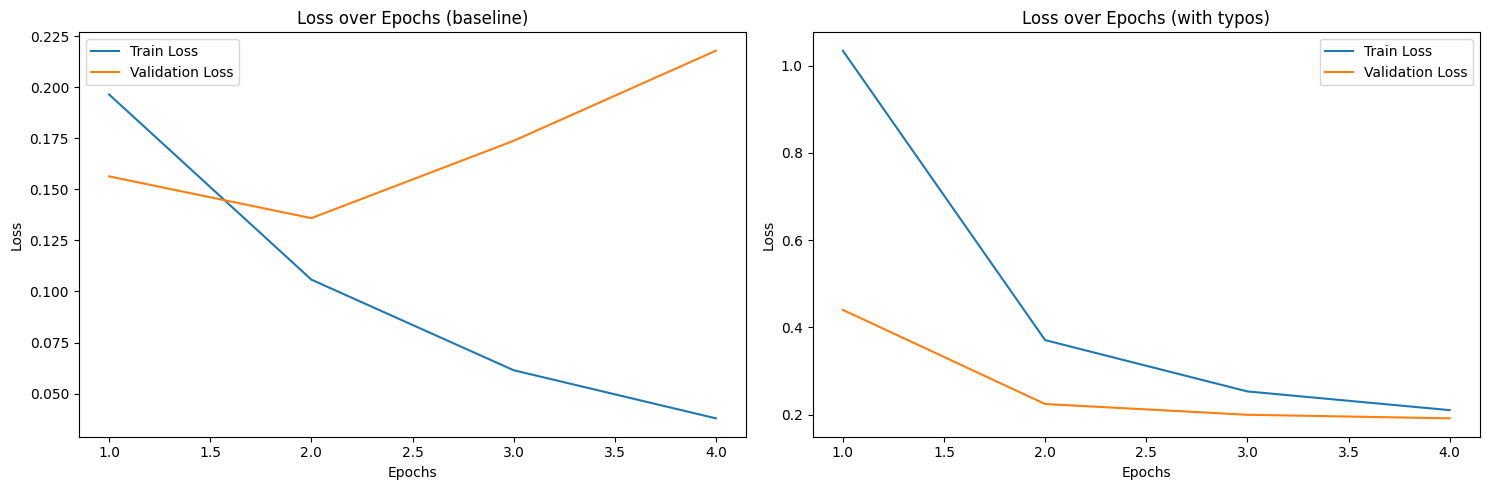

Accuracy for model with no typos was [0.9483937823834196]
Accuracy for model with 69.24% typos is [0.9387968589272748]


In [ ]:
# Plot the training and validation losses
epochs_range_1 = range(1, len(history_typos1['train_loss']) + 1)

fig, axes = plt.subplots(2, 2, figsize=(15, 5))

# Plot training and validation loss (with no typos)
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, history_base['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_base['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (baseline)')
plt.legend()

# Plot training and validation loss (with typos)
plt.subplot(1, 2, 2)
plt.plot(epochs_range_1, history_typos1['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_typos1['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (with typos)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Accuracy for model with no typos was {history_base['test_accuracy']}")
print(f"Accuracy for model with 69.24% typos is {history_typos1['test_accuracy']}")

For this model setup as well, the training and validation loss values remain much worse for all epochs with 69.24% syntactic noise. The impact to the accuracy is not as significant as the previous experiment. Let's look at other noise levels.

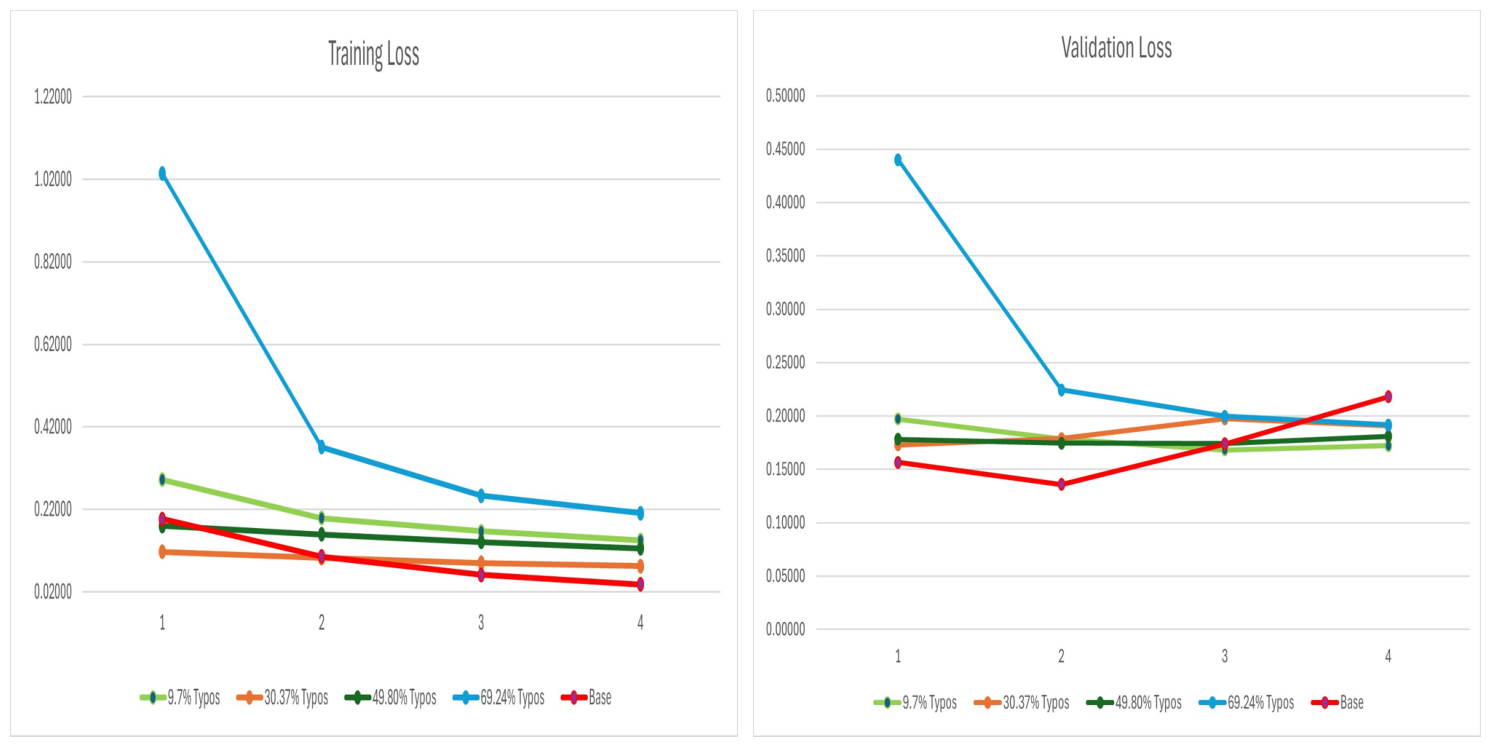

In [ ]:
# Load images
typos_training_loss1 = Image.open("Typos_trainingloss1.jpg")
typos_validation_loss1 = Image.open("Typos_validationloss1.jpg")

# Resize images (adjust as needed)
new_size = (1000, 1000)  # Width x Height
typos_training_loss1 = typos_training_loss1.resize(new_size)
typos_validation_loss1 = typos_validation_loss1.resize(new_size)

# Display side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes[0].imshow(typos_training_loss1)
axes[0].axis('off')

axes[1].imshow(typos_validation_loss1)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In this setup, where the last two embedding layers (layers 10 and 11), the pooler layer, and the classifier layer are left unfrozen, we observe a notable trend in how the model responds to syntactic noise. Initially, the injection of noise at any level results in consistently higher loss values compared to the baseline model (no noise), indicating a drop in performance during the early stages of training. Up to epoch 4, there appears to be a linear relationship between noise level and loss, with higher noise generally corresponding to higher loss.

However, after epoch 4, an interesting shift occurs: the model trained on noisy data begins to outperform the base model in terms of validation loss. This suggests that the model starts to generalize better than the noise-free baseline, despite the syntactic corruption. One plausible explanation is that by unfreezing the last two embedding layers, the model gains the capacity to adapt its internal representations to account for the syntactic noise present in the data. Over time, these layers may be learning to compensate for the noise, allowing the model to extract more robust features.

This improvement after epoch 4 highlights the benefit of partial fine-tuning in noisy environments. Rather than overfitting to the noise, the model appears to learn more generalizable patterns—possibly by denoising the input representations through additional training.

## Semantic Noise (Misinterpretation)

In [ ]:
# define optimizer
optimizer_new1 = Adam(filter(lambda p: p.requires_grad, model_new1.parameters()), lr=2e-5)

Similar to previous experimentation, we will inject various amounts of semantic noise to the dataset and re-train our new customized model.

In [ ]:
# Randomly sample "x" indices from this combined pool
sampled_indices_interpret = random.sample(combined_indices_interpret, 40000)

# Extract the corresponding queries
sampled_df_misinterpret = train_df.loc[sampled_indices_interpret, 'query']

# Save the original indices
samples_idx_misinterpret = sampled_df_misinterpret.index

# change the interpretatin of the chosen samples
def misinterpret_where(text, seed=None):

    if seed is not None:
        random.seed(seed)

    # change the meaning of "location" by replacing "where" with who/how/why
    if text.startswith("where"):
        replacement = random.choice(["who", "how", "why"])
        return text.replace("where", replacement, 1)  # Replace only the first occurrence

    # change the meaning of "entity" by replacing "what" with where
    elif text.startswith("what"):
        return text.replace("what", "where", 1)  # Replace only the first occurrence

    # change the meaning of "numeric" by removing "long" only if not already changed
    elif "long" in text and not text.startswith("where") and not text.startswith("what"):
        return text.replace("long", "", 1)  # Replace only the first occurrence

    else:
        return text  # Return unchanged if it doesn't start with "Where"

# Apply the replacement function to change query interpretation
sampled_df_misinterpret1 = sampled_df_misinterpret.apply(lambda x: misinterpret_where(x, seed=random_state))

In [ ]:
# Make a copy to avoid modifying original train_df
train_df_misinterpret1 = train_df.copy()

# Replace the selected rows' 'query' with the noisy version
train_df_misinterpret1.loc[sampled_indices_interpret, 'query'] = sampled_df_misinterpret.values

In [ ]:
# Tokenize the queries in train_df_misinterpret1
train_misinterpret_encodings1 = tokenizer_new(
    train_df_misinterpret1['query'].tolist(),       # Input text
    truncation=True,                               # Truncate to max length
    padding=True,                                  # Pad to max length
    max_length=128,                                # Optional: set max sequence length
    return_tensors="pt"                            # Return PyTorch tensors
)

In [ ]:
# Create training dataset (val_dataset and test_dataset will remain unchanged)
train_misinterpret_dataset1 = QueryDataset(train_misinterpret_encodings1, y_train.tolist())

# create data loader for this training dataset. We can reuse the dataloaders for test and validation datasets.
train_misinterpret_dataloader1 = DataLoader(train_misinterpret_dataset1, batch_size=16, shuffle=True)

In [ ]:
# Number of epochs=4, optimizer = Adam, batch size = 16 (remain same)

# setup tracking for training
history_misinterpret1 = {}  # empty dict to store training history of the new model
history_misinterpret1['val_loss'] = []  # stores validation loss values
history_misinterpret1['train_loss'] = []  # stores training loss values

# setting up a progress bar for epochs
with trange(epochs, desc="Epoch") as pbar:

    for epoch in pbar:
        model_new1.train()  # put the model in training mode
        total_loss  = 0.0  # track the training loss

        # iterate over training data in batchs using train_typos_dataloader.
        for batch in tqdm(train_misinterpret_dataloader1, desc=f"Training {epoch}", total=len(train_misinterpret_dataloader1), leave=False):

            # send batch (tuple of below input parameters & labels) to GPU and separate for the model
            batch = {k: v.to(device) for k, v in batch.items()}   # Send all tensor values to GPU
            input_ids, input_mask, input_types, labels = batch  # unpack those parameters of the tuple

            # pass these parameters thru model to perform forward pass. This will compute model's output (includes training loss)
            output = model_new1(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch['token_type_ids'],
                labels=batch['labels']
            )

            # back propagation
            output.loss.backward() # computes gradients by backpropagation using the loss
            optimizer_new1.step() # use gradients in optimizer to update model's parameters
            optimizer_new1.zero_grad() # clear out gradients of optimized tensors to avoid accumulation of gradients between different batches

            # keep track of total train loss. Need to multiply loss per sample by batch size for total loss
            total_loss += output.loss.item() * batch['input_ids'].size(0)

        # calcualte the avg. training loss and add it to the train_loss
        total_loss  = total_loss / train_size           # train_size remains unchanged
        history_misinterpret1['train_loss'].append(total_loss)


        # print the train loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

        # at end of epoch, report the evaluation
        model_new1.eval()  # Set model to evaluation mode
        total_loss  = 0.0  #rest the total loss to 0 to track the validation loss

        # turn of gradient calculation as we're only evaluating the model
        with torch.no_grad():

            # evaluation in batches (same as above). No change to val_dataloader
            for batch in tqdm(val_dataloader, desc=f"Evaluating {epoch}", total = len(val_dataloader), leave=False):

                batch = {k: v.to(device) for k, v in batch.items()}

                output = model_new1(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    token_type_ids=batch['token_type_ids'],
                    labels=batch['labels']
                )

                total_loss += output.loss.item() * batch['input_ids'].size(0)

            total_loss  = total_loss / val_size
            history_misinterpret1['val_loss'].append(total_loss)

        # print the eval loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

In [ ]:
history_misinterpret1

{'val_loss': [0.24967022535211644,
  0.25383836468876125,
  0.25825534236436487,
  0.25690381759265285],
 'train_loss': [0.03817627691913856,
  0.03572597230523222,
  0.0336692718740999,
  0.03268633963584242]}

In [ ]:
# store the model accuracy of the new model
history_misinterpret1['test_accuracy'] = []

# get predicted labels and true labels
all_preds_misinterpret = []
all_labels_misinterpret = []

 # Run evaluation without tracking gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc=f"Evaluating {epoch}", total=len(test_dataloader), leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']

        output = model_new1(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            labels=labels
        )

        # Predictions: take argmax if multi-class (logits), or round for binary (sigmoid output)
        logits = output.logits
        preds = torch.argmax(logits, dim=1) if logits.shape[1] > 1 else torch.round(torch.sigmoid(logits)).squeeze()

        # Store predictions and labels as numpy arrays
        all_preds_misinterpret.extend(preds.cpu().numpy())
        all_labels_misinterpret.extend(labels.cpu().numpy())


# Compute accuracy
accuracy_misinterpret = accuracy_score(all_labels_misinterpret, all_preds_misinterpret)
history_misinterpret1['test_accuracy'].append(accuracy_misinterpret)
print("complete")

Evaluating 3:   0%|          | 0/604 [00:00<?, ?it/s]

complete


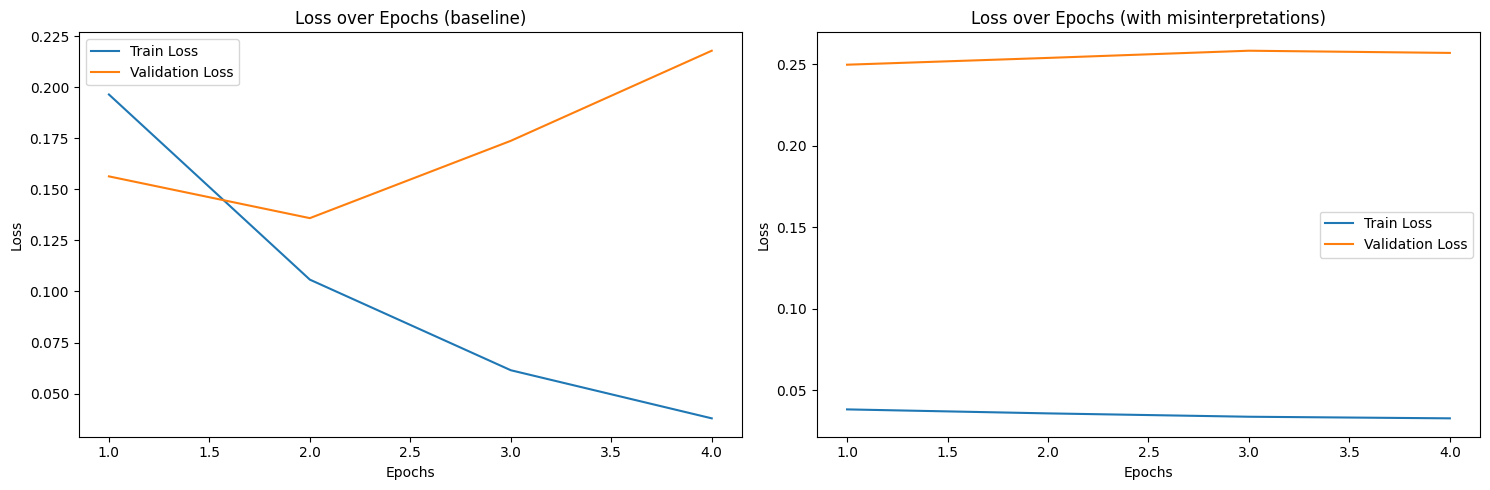

Accuracy for baseline model was [0.9483937823834196]
Accuracy for model with 49.59% misinterpreted samples is [0.9453886001036269]


In [ ]:
# Plot the training and validation losses
epochs_range_1 = range(1, len(history_misinterpret1['train_loss']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss (with no misinterpretations)
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, history_base['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_base['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (baseline)')
plt.legend()

# Plot training and validation loss (with misinterpretations)
plt.subplot(1, 2, 2)
plt.plot(epochs_range_1, history_misinterpret1['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_misinterpret1['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (with misinterpretations)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Accuracy for baseline model was {history_base['test_accuracy']}")
print(f"Accuracy for model with 49.59% misinterpreted samples is {history_misinterpret1['test_accuracy']}")

Looking at the semantic noise, we see different trend as compared to previous experiment because we can see that the training loss is much lower (remains almost same for all epochs) than the base model. So far we have been seeing higher training loss (worse) due to noise. However, despite the seemingly better fit to the training data, the validation loss remains consistently worse than the base model, indicating poor generalization. This discrepancy between training and validation loss suggests that the model is overfitting to the noisy semantic content rather than learning meaningful generalizable features. Maybe this is why the accuracy is also very similar to that of base model. But this behavior is for 49.59% of noise. Let's look at the other noise levels.

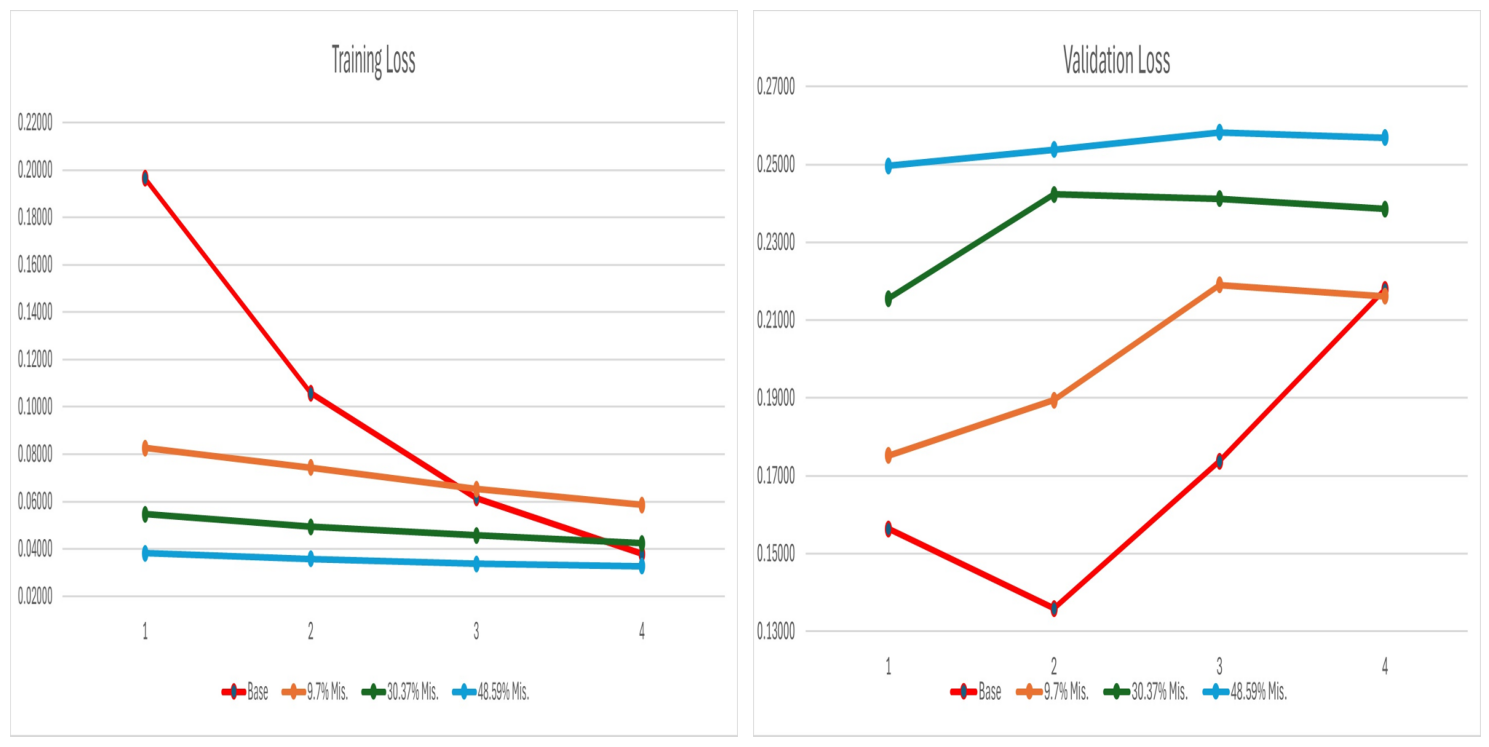

In [ ]:
# Load images
misinterpret_training_loss1 = Image.open("Misinterpret_trainingloss1.jpg")
misinterpret_validation_loss1 = Image.open("Misinterpret_validationloss1.jpg")

# Resize images (adjust as needed)
new_size = (1000, 1000)  # Width x Height
misinterpret_training_loss1 = misinterpret_training_loss1.resize(new_size)
misinterpret_validation_loss1 = misinterpret_validation_loss1.resize(new_size)

# Display side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes[0].imshow(misinterpret_training_loss1)
axes[0].axis('off')

axes[1].imshow(misinterpret_validation_loss1)
axes[1].axis('off')

plt.tight_layout()
plt.show()

Across all levels of semantic noise, the training loss remains relatively flat across epochs, indicating that the model quickly adapts to the noise in the training data regardless of its level. This consistent behavior across noise levels suggests that the model is highly flexible due to the unfrozen layers and may be memorizing the noisy input rather than learning robust features.

However, this quick adaptation comes at a cost. While the training loss stays low, validation loss clearly increases with the level of semantic noise, showing a linear degradation in generalization ability. This means that even though the model appears to perform well on the training set, it fails to carry that performance over to unseen data—a textbook case of overfitting, exacerbated by the semantic distortion.

The only slight deviation from this pattern is at the 49.59% noise level, where training and validation losses stabilize closer to the base model by epoch 4. This might indicate a plateau in the negative effect of semantic noise, or possibly the model beginning to learn some generalized patterns despite the noise—but not enough to outperform or even match the base model consistently.
Overall, semantic noise has a strongly negative and linear impact on model performance, despite what low training loss may suggest.

# Experiment 3 (Freeze 0-1 encoding layers)

In this experiment, we will freeze the first two encoding layers (0 and 1), last pooler layer, and classifier layer.

In [ ]:
# Load the model
model_new2 = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=5,
                                                      output_hidden_states=False
                                                     )

# Load the tokenizer
tokenizer_new2 = BertTokenizer.from_pretrained('bert-base-uncased')

# place the based model to GPU if available
model_new2.to(device)

In [ ]:
# Freeze all layers first
for param in model_new2.bert.parameters():
    param.requires_grad = False

# Then unfreeze the first encoder layers
for name, param in model_new2.bert.named_parameters():
    if "encoder.layer.0" in name or "encoder.layer.1" in name:
        param.requires_grad = True

# Unfreeze embeddings
for param in model_new2.bert.embeddings.parameters():
    param.requires_grad = True

# only train the parameters for pooler layer of BERT (final layer before our classifier layer)
for param in model_new2.bert.pooler.parameters():
    param.requires_grad = True

# only train the classifier layer that we added to BERT model
for param in model_new2.classifier.parameters():
    param.requires_grad = True

In [ ]:
trainable_params_new2 = sum(p.numel() for p in model_new2.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params_new2}")

Trainable parameters: 52783109


With this setup, we have about 32M more trainable parameters than the previous setup where we unfroze last two encoding layers.

In [ ]:
# define optimizer
optimizer_new2 = Adam(filter(lambda p: p.requires_grad, model_new2.parameters()), lr=2e-5)

## Noise (Typos)

In [ ]:
# Select n random samples from train_df dataset
sampled = train_df['query'].sample(n=57000, random_state=random_state)
samples_idx = sampled.index  # Save the original indices
sampled_df = sampled.reset_index(drop=True)  # Reset index for clean iteration

# Apply the typo function to each row in sampled_df
sampled_df_with_typos = sampled_df.apply(lambda x: add_typos_to_text(x, seed_base=random_state))

In [ ]:
# Make a copy to avoid modifying original train_df
train_df_typos = train_df.copy()

# Replace the selected rows' 'query' with the noisy version
train_df_typos.loc[samples_idx, 'query'] = sampled_df_with_typos.values

In [ ]:
# Tokenize the queries in train_df_typos
train_typos_encodings = tokenizer_new2(
    train_df_typos['query'].tolist(),       # Input text
    truncation=True,                        # Truncate to max length
    padding=True,                           # Pad to max length
    max_length=128,                         # Optional: set max sequence length
    return_tensors="pt"                     # Return PyTorch tensors
)

In [ ]:
# Create training dataset (val_dataset and test_dataset will remain unchanged)
train_typos_dataset = QueryDataset(train_typos_encodings, y_train.tolist())

# create data loader for this training dataset. We can reuse the dataloaders for test and validation datasets.
train_typos_dataloader = DataLoader(train_typos_dataset, batch_size=16, shuffle=True)

In [ ]:
# Number of epochs=4, optimizer = Adam, batch size = 16 (remain same)

# setup tracking for training
history_typos2 = {}  # empty dict to store training history of the new model
history_typos2['val_loss'] = []  # stores validation loss values
history_typos2['train_loss'] = []  # stores training loss values

# setting up a progress bar for epochs
with trange(epochs, desc="Epoch") as pbar:

    for epoch in pbar:
        model_new2.train()  # put the model in training mode
        total_loss  = 0.0  # track the training loss

        # iterate over training data in batchs using train_typos_dataloader.
        for batch in tqdm(train_typos_dataloader, desc=f"Training {epoch}", total=len(train_typos_dataloader), leave=False):

            # send batch (tuple of below input parameters & labels) to GPU and separate for the model
            batch = {k: v.to(device) for k, v in batch.items()}   # Send all tensor values to GPU
            input_ids, input_mask, input_types, labels = batch  # unpack those parameters of the tuple

            # pass these parameters thru model to perform forward pass. This will compute model's output (includes training loss)
            output = model_new2(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch['token_type_ids'],
                labels=batch['labels']
            )

            # back propagation
            output.loss.backward() # computes gradients by backpropagation using the loss
            optimizer_new2.step() # use gradients in optimizer to update model's parameters
            optimizer_new2.zero_grad() # clear out gradients of optimized tensors to avoid accumulation of gradients between different batches

            # keep track of total train loss. Need to multiply loss per sample by batch size for total loss
            total_loss += output.loss.item() * batch['input_ids'].size(0)

        # calcualte the avg. training loss and add it to the train_loss
        total_loss  = total_loss / train_size           # train_size remains unchanged
        history_typos2['train_loss'].append(total_loss)


        # print the train loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

        # at end of epoch, report the evaluation
        model_new2.eval()  # Set model to evaluation mode
        total_loss  = 0.0  #rest the total loss to 0 to track the validation loss

        # turn of gradient calculation as we're only evaluating the model
        with torch.no_grad():

            # evaluation in batches (same as above). No change to val_dataloader
            for batch in tqdm(val_dataloader, desc=f"Evaluating {epoch}", total = len(val_dataloader), leave=False):

                batch = {k: v.to(device) for k, v in batch.items()}

                output = model_new2(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    token_type_ids=batch['token_type_ids'],
                    labels=batch['labels']
                )

                total_loss += output.loss.item() * batch['input_ids'].size(0)

            total_loss  = total_loss / val_size
            history_typos2['val_loss'].append(total_loss)

        # print the eval loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")


In [ ]:
history_typos2

{'val_loss': [0.257046793954931,
  0.26963745130593,
  0.248162999762138,
  0.248162999762138],
 'train_loss': [0.0209158365662695,
  0.0151414520286516,
  0.0130701272450388,
  0.011619699746512]}

In [ ]:
# store the validation accuracy of the new model
history_typos2['test_accuracy'] = []

# get predicted labels and true labels
all_preds_typos = []
all_labels_typos = []

 # Run evaluation without tracking gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc=f"Evaluating {epoch}", total=len(test_dataloader), leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']

        output = model_new2(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            labels=labels
        )

        # Predictions: take argmax if multi-class (logits), or round for binary (sigmoid output)
        logits = output.logits
        preds = torch.argmax(logits, dim=1) if logits.shape[1] > 1 else torch.round(torch.sigmoid(logits)).squeeze()

        # Store predictions and labels as numpy arrays
        all_preds_typos.extend(preds.cpu().numpy())
        all_labels_typos.extend(labels.cpu().numpy())


# Compute accuracy
accuracy_typos = accuracy_score(all_labels_typos, all_preds_typos)
history_typos2['test_accuracy'].append(accuracy_typos)
print("complete")

Evaluating 3:   0%|          | 0/604 [00:00<?, ?it/s]

complete


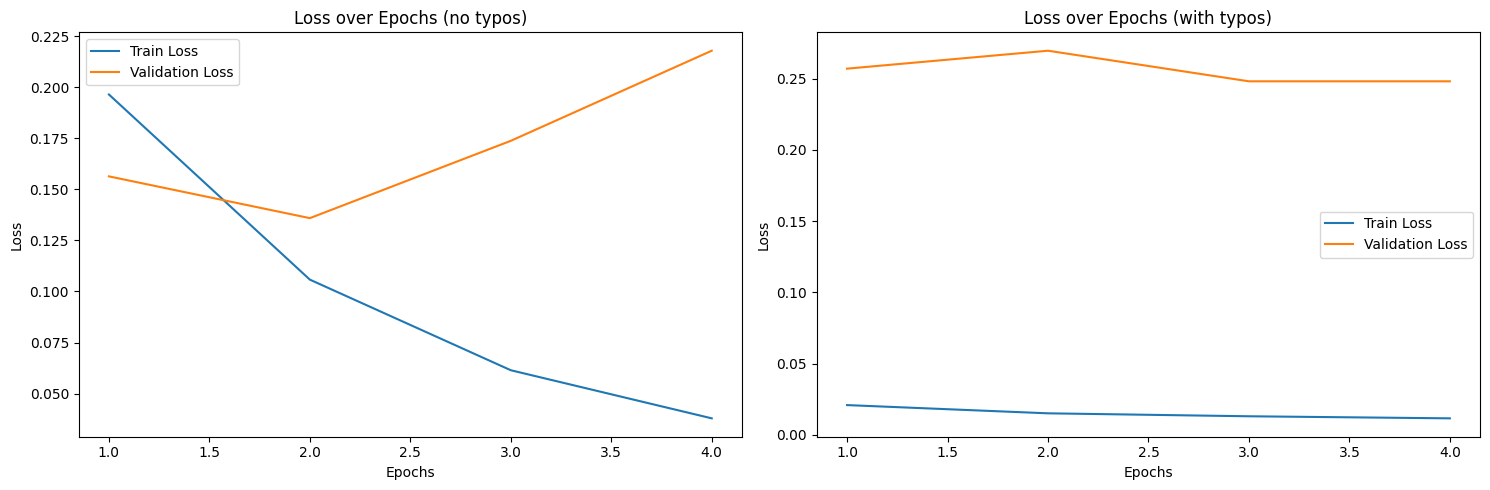

Accuracy for baseline [0.9453886010362694]
Accuracy for model with 69.24% typos is [0.9472530051483482]


In [ ]:
# Plot the training and validation losses
epochs_range_1 = range(1, len(history_typos2['train_loss']) + 1)

fig, axes = plt.subplots(2, 2, figsize=(15, 5))

# Plot training and validation loss (with no typos)
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, history_base['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_base['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (no typos)')
plt.legend()

# Plot training and validation loss (with typos)
plt.subplot(1, 2, 2)
plt.plot(epochs_range_1, history_typos2['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_typos2['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (with typos)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Accuracy for baseline {history_base['test_accuracy']}")
print(f"Accuracy for model with 69.24% typos is {history_typos2['test_accuracy']}")

Looking at the training loss values for 69.24% noise, we see that the training loss starts lower (better) and stays same for all epochs as compared to the base model. This is similar behavior we saw in previous experiment for semantic type noise. But if we look in the validation loss values then, we can clearly see that the loss values are higher (worse) than the base model. Overall, this indicates that this model's generalization performance has degraded due to noise. But let's look at other levels of noise.

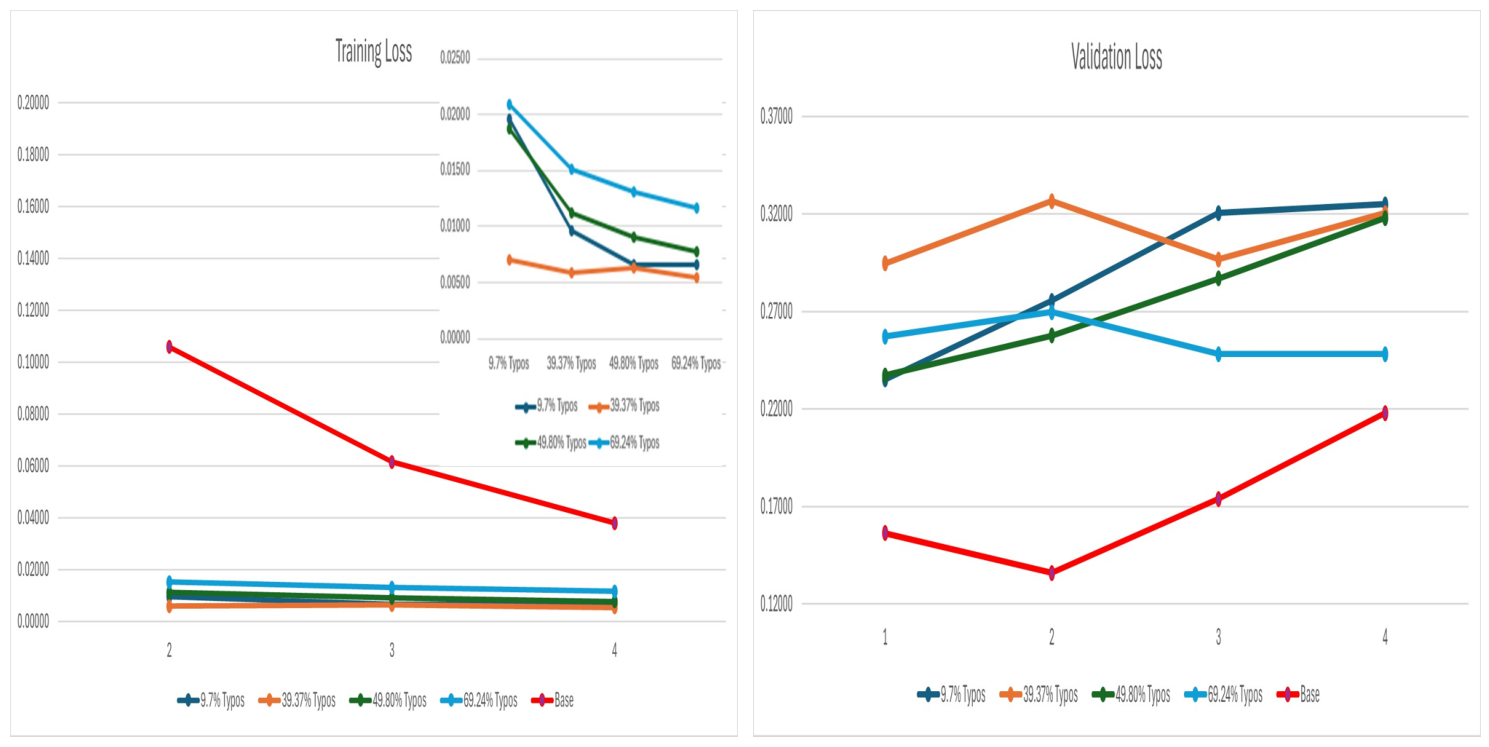

In [ ]:
# Load images
typos_training_loss2 = Image.open("typos_training_loss2.jpg")
typos_validation_loss2 = Image.open("typos_validation_loss2.jpg")

# Resize images (adjust as needed)
new_size = (1000, 1000)  # Width x Height
typos_training_loss2 = typos_training_loss2.resize(new_size)
typos_validation_loss2 = typos_validation_loss2.resize(new_size)

# Display side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes[0].imshow(typos_training_loss2)
axes[0].axis('off')

axes[1].imshow(typos_validation_loss2)
axes[1].axis('off')

plt.tight_layout()
plt.show()

Across all levels of noise, the training loss values are consistently lower than those of the base model throughout all epochs. However, unlike the base model—where the training loss steadily decreases—the noisy models show minimal change in training loss over epochs, suggesting early memorization or limited learning progression beyond initial adaptation. Notably, the highest noise level (69.24%) results in the worst training loss among the noisy variants, though still better than the base model's values.  
When examining validation loss, a clear degradation in generalization performance emerges. All noisy models exhibit significantly higher validation loss compared to the base model, indicating overfitting or reduced ability to generalize beyond the noisy training data. However, the relationship between noise level and validation loss is not linear—the loss does not consistently increase with more noise, implying that other factors such as which layers are trainable may interact with the noise in complex ways. Overall, this setup leads to reduced generalization capability, even when training loss appears deceptively favorable.

## Noise (Misinterpretation)

In [ ]:
# define optimizer
optimizer_new2 = Adam(filter(lambda p: p.requires_grad, model_new2.parameters()), lr=2e-5)

In [ ]:
# Randomly sample "x" indices from this combined pool
sampled_indices_interpret = random.sample(combined_indices_interpret, 40000)

# Extract the corresponding queries
sampled_df_misinterpret = train_df.loc[sampled_indices_interpret, 'query']

# Save the original indices
samples_idx_misinterpret = sampled_df_misinterpret.index

# change the interpretatin of the chosen samples
def misinterpret_where(text, seed=None):

    if seed is not None:
        random.seed(seed)

    # change the meaning of "location" by replacing "where" with who/how/why
    if text.startswith("where"):
        replacement = random.choice(["who", "how", "why"])
        return text.replace("where", replacement, 1)  # Replace only the first occurrence

    # change the meaning of "entity" by replacing "what" with where
    elif text.startswith("what"):
        return text.replace("what", "where", 1)  # Replace only the first occurrence

    # change the meaning of "numeric" by removing "long" only if not already changed
    elif "long" in text and not text.startswith("where") and not text.startswith("what"):
        return text.replace("long", "", 1)  # Replace only the first occurrence

    else:
        return text  # Return unchanged if it doesn't start with "Where"

# Apply the replacement function to change query interpretation
sampled_df_misinterpret2 = sampled_df_misinterpret.apply(lambda x: misinterpret_where(x, seed=random_state))

In [ ]:
# Make a copy to avoid modifying original train_df
train_df_misinterpret2 = train_df.copy()

# Replace the selected rows' 'query' with the noisy version
train_df_misinterpret2.loc[sampled_indices_interpret, 'query'] = sampled_df_misinterpret.values

In [ ]:
# Tokenize the queries in train_df_misinterpret2
train_misinterpret_encodings2 = tokenizer_new2(
    train_df_misinterpret2['query'].tolist(),       # Input text
    truncation=True,                               # Truncate to max length
    padding=True,                                  # Pad to max length
    max_length=128,                                # Optional: set max sequence length
    return_tensors="pt"                            # Return PyTorch tensors
)

In [ ]:
# Create training dataset (val_dataset and test_dataset will remain unchanged)
train_misinterpret_dataset2 = QueryDataset(train_misinterpret_encodings2, y_train.tolist())

# create data loader for this training dataset. We can reuse the dataloaders for test and validation datasets.
train_misinterpret_dataloader2 = DataLoader(train_misinterpret_dataset2, batch_size=16, shuffle=True)

In [ ]:
# Number of epochs=4, optimizer = Adam, batch size = 16 (remain same)

# setup tracking for training
history_misinterpret2 = {}  # empty dict to store training history of the new model
history_misinterpret2['val_loss'] = []  # stores validation loss values
history_misinterpret2['train_loss'] = []  # stores training loss values

# setting up a progress bar for epochs
with trange(epochs, desc="Epoch") as pbar:

    for epoch in pbar:
        model_new2.train()  # put the model in training mode
        total_loss  = 0.0  # track the training loss

        # iterate over training data in batchs using train_typos_dataloader.
        for batch in tqdm(train_misinterpret_dataloader2, desc=f"Training {epoch}", total=len(train_misinterpret_dataloader2), leave=False):

            # send batch (tuple of below input parameters & labels) to GPU and separate for the model
            batch = {k: v.to(device) for k, v in batch.items()}   # Send all tensor values to GPU
            input_ids, input_mask, input_types, labels = batch  # unpack those parameters of the tuple

            # pass these parameters thru model to perform forward pass. This will compute model's output (includes training loss)
            output = model_new2(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch['token_type_ids'],
                labels=batch['labels']
            )

            # back propagation
            output.loss.backward() # computes gradients by backpropagation using the loss
            optimizer_new2.step() # use gradients in optimizer to update model's parameters
            optimizer_new2.zero_grad() # clear out gradients of optimized tensors to avoid accumulation of gradients between different batches

            # keep track of total train loss. Need to multiply loss per sample by batch size for total loss
            total_loss += output.loss.item() * batch['input_ids'].size(0)

        # calcualte the avg. training loss and add it to the train_loss
        total_loss  = total_loss / train_size           # train_size remains unchanged
        history_misinterpret2['train_loss'].append(total_loss)


        # print the train loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

        # at end of epoch, report the evaluation
        model_new2.eval()  # Set model to evaluation mode
        total_loss  = 0.0  #rest the total loss to 0 to track the validation loss

        # turn of gradient calculation as we're only evaluating the model
        with torch.no_grad():

            # evaluation in batches (same as above). No change to val_dataloader
            for batch in tqdm(val_dataloader, desc=f"Evaluating {epoch}", total = len(val_dataloader), leave=False):

                batch = {k: v.to(device) for k, v in batch.items()}

                output = model_new2(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    token_type_ids=batch['token_type_ids'],
                    labels=batch['labels']
                )

                total_loss += output.loss.item() * batch['input_ids'].size(0)

            total_loss  = total_loss / val_size
            history_misinterpret2['val_loss'].append(total_loss)

        # print the eval loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")


In [ ]:
history_misinterpret2

{'val_loss': [0.42795178097658837,
  0.40576638999657566,
  0.4514324418205557,
  0.4333894182268269],
 'train_loss': [0.002427447615552828,
  0.00249562132215436,
  0.0019360038491812767,
  0.001837145114354215]}

In [ ]:
# store the model accuracy of the new model
history_misinterpret2['test_accuracy'] = []

# get predicted labels and true labels
all_preds_misinterpret2 = []
all_labels_misinterpret2 = []

 # Run evaluation without tracking gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc=f"Evaluating {epoch}", total=len(test_dataloader), leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']

        output = model_new2(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            labels=labels
        )

        # Predictions: take argmax if multi-class (logits), or round for binary (sigmoid output)
        logits = output.logits
        preds = torch.argmax(logits, dim=1) if logits.shape[1] > 1 else torch.round(torch.sigmoid(logits)).squeeze()

        # Store predictions and labels as numpy arrays
        all_preds_misinterpret2.extend(preds.cpu().numpy())
        all_labels_misinterpret2.extend(labels.cpu().numpy())


# Compute accuracy
accuracy_misinterpret2 = accuracy_score(all_labels_misinterpret2, all_preds_misinterpret2)
history_misinterpret2['test_accuracy'].append(accuracy_misinterpret2)
print("complete")

Evaluating 3:   0%|          | 0/604 [00:00<?, ?it/s]

complete


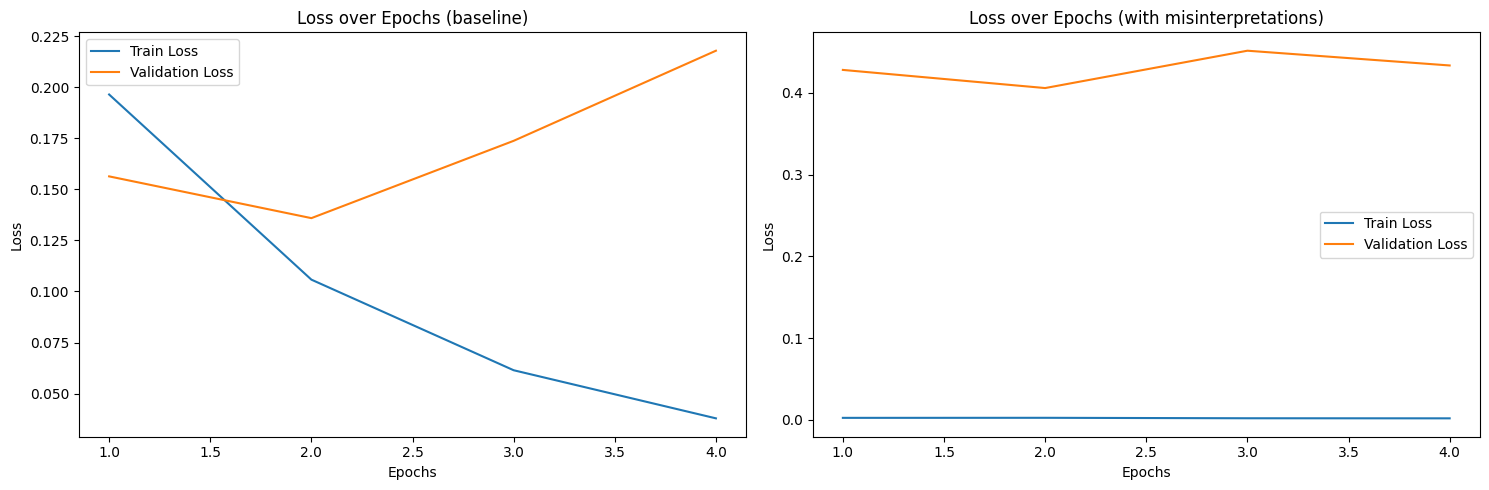

Accuracy for baseline model was [0.9453886010362694]
Accuracy for model with 48.59% misinterpreted samples is [0.9472538860103626]


In [ ]:
# Plot the training and validation losses
epochs_range_1 = range(1, len(history_misinterpret2['train_loss']) + 1)

fig, axes = plt.subplots(2, 2, figsize=(15, 5))

# Plot training and validation loss (with no misinterpretations)
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, history_base['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_base['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (baseline)')
plt.legend()

# Plot training and validation loss (with misinterpretations)
plt.subplot(1, 2, 2)
plt.plot(epochs_range_1, history_misinterpret2['train_loss'], label='Train Loss')
plt.plot(epochs_range_1, history_misinterpret2['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (with misinterpretations)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Accuracy for baseline model was {history_base['test_accuracy']}")
print(f"Accuracy for model with 48.59% misinterpreted samples is {history_misinterpret2['test_accuracy']}")

Looking at 48.59% of semantic noise, we can see the same behavior like previous step in terms of training loss. They start lower than base model and remains unchanged for all 4 epochs. But if we look into the validation loss plot then the loss values start higher (worse) and remain unchanged for all 4 epochs. Let's look at other noise levels for further analysis.

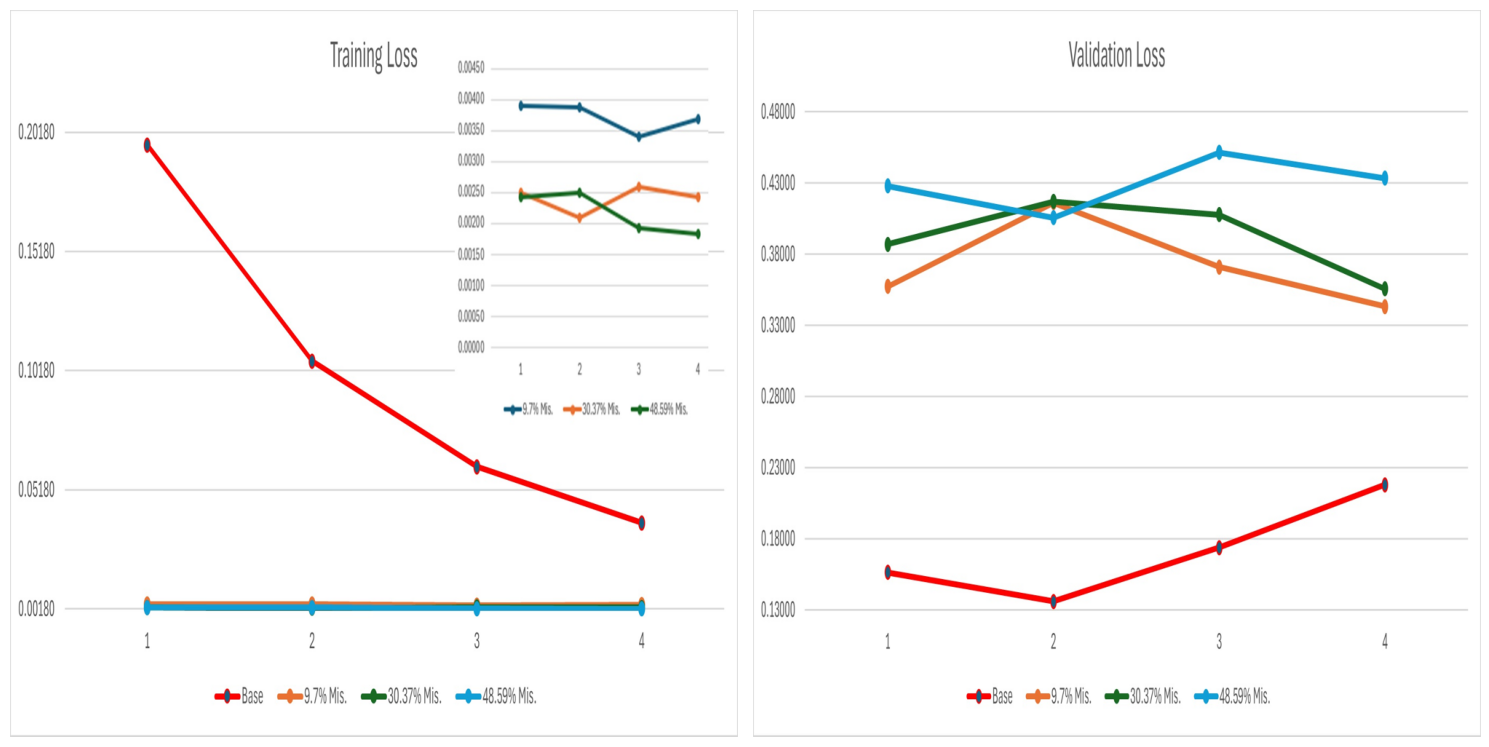

In [ ]:
# Load images
misinterpret_training_loss2 = Image.open("Misinterpret_trainingloss2.jpg")
misinterpret_validation_loss2 = Image.open("Misinterpret_validationloss2.jpg")

# Resize images (adjust as needed)
new_size = (1000, 1000)  # Width x Height
misinterpret_training_loss2 = misinterpret_training_loss2.resize(new_size)
misinterpret_validation_loss2 = misinterpret_validation_loss2.resize(new_size)

# Display side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes[0].imshow(misinterpret_training_loss2)
axes[0].axis('off')

axes[1].imshow(misinterpret_validation_loss2)
axes[1].axis('off')

plt.tight_layout()
plt.show()